# NYC Parking Tickets Fiscal Year 2021: An Exploratory Analysis
##### Oliver Sarzynski
<br>
<img src='https://newyorkparkingticket.com/wp-content/uploads/2020/03/TICKETS-windshield.jpeg' width=600 height=600/>
Credit: <a href='https://newyorkparkingticket.com/passenger-vehicles/'> "NYC Parking Ticket"</a>          
<br>
<br>The primary purpose of this project is to practice and showcase some of the data analysis skills I have recently picked up through both independent study and completion of <a href='https://coursera.org/share/e583e96d439270690bce1b01b7966525'> IBM's Professional Data Analysis Certification Program</a>.

<br>The following is my first project using python outside of an academic setting and I would greatly appreciate any and all feedback regarding simplifying my code, figure layouts/vizualisation choices, and overall organization.
<br>After cleaning, <a href="https://data.cityofnewyork.us/City-Government/Parking-Violations-Issued-Fiscal-Year-2021/kvfd-bves">this dataset</a> of over 15M rows has been reduced to 6.6M, representing all days between July 2020 and June 2021 inclusive.  
<br>As I was concerned about my CPU's temperature readings upon initially observing the dataset, I opted to immediately drop all rows with Nan values. 
<br>Values of '0' or 'N/A'-like strings discovered later in the cleaning process were replaced with median/mode where appropriate to preserve data.

<br>Violation codes were replaced with violation descriptions and their corresponding fine values provided in a separate CSV provided by NYC Open Data.
<br> If you are interested, you can find the data cleaning notebook <a href='404 link not found'> here</a>.

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Polygon
import squarify
import circlify
import seaborn as sns
import datetime
from datetime import datetime as dt
import calendar
from dateutil.relativedelta import relativedelta

df = pd.read_csv('C:\\Users\\sarzy\\Documents\\Jupyter-lab\\2022 Parking Violations\\2021_parking_violations_cleaned_all_final.csv')

#minor adjustment to body type labels
body_dict = {'REFRIGERATOR TRAILER':'SEMI-TRAILER', 'TRACTOR':'SEMI-TRAILER', 'SUBURBAN':'SUV', 'TRAILER':'SEMI-TRAILER'}
df.replace({'vehicle_body_type':body_dict}, inplace = True)

total_revenue = df.violation_fine.sum()
print('Total Number of Parking Violations in NYC Fiscal Year 2021:' , '{:,}'.format(len(df)))
print('Estimated Total Revenue: ' + '$' + '{:,}'.format(int(total_revenue)))

Total Number of Parking Violations in NYC Fiscal Year 2021: 6,578,587
Estimated Total Revenue: $483,212,847


A <a href = 'https://www.spotangels.com/blog/nyc-parking-tickets-where-youre-likely-to-get-one-and-how-spotangels-can-pay-for-it/'> similar study</a> on violations between October 2020 and September 2021 by SpotAngels estimated total revenue to be $260,000,000, 
<br> which is far lower than what we have calculated between June 2020 and July 2021, even after dropping many rows due to incomplete data.
<br> It is likely that SpotAngels have accounted for revenue lost due to violation disputes.

### Total Parking Violations by Month:

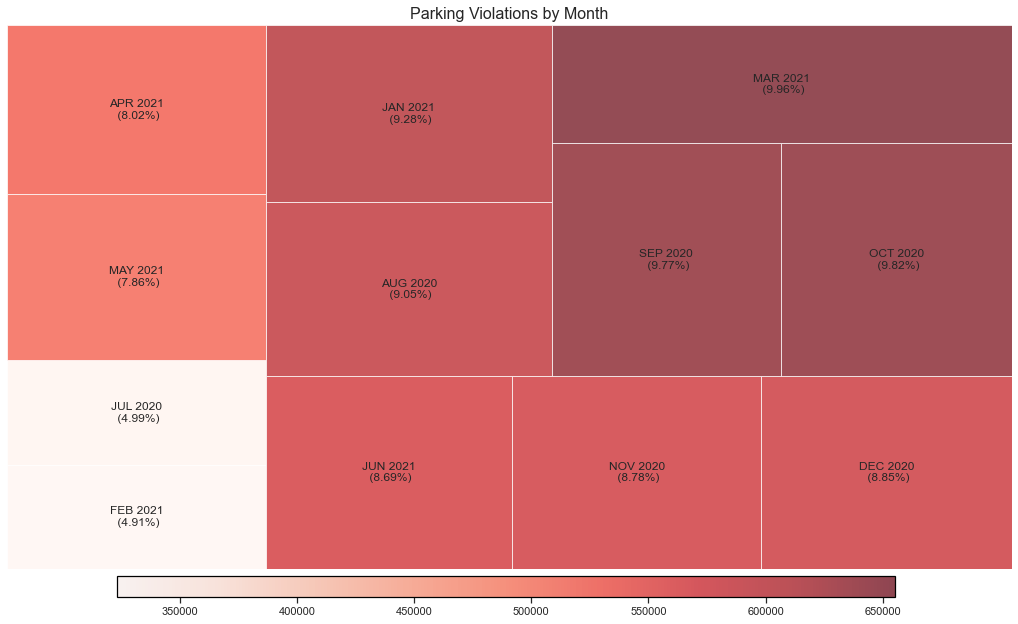

In [44]:
#Month data in percents:
months_sort = df[['month_year','issue_date']].sort_values('issue_date')
months = pd.DataFrame(months_sort.month_year.value_counts(sort=False))
monthsize = df.groupby('month_year', sort=False).size().reset_index(name='sums').sort_values('sums')
monthsize['pct'] = (round((monthsize['sums']/(monthsize['sums'].sum()) * 100), 2))
month_labels = monthsize.apply(lambda x: str(x[0]) + '\n (' + str(x[2]) + '%)', axis=1)

#Mapping color palette:
cmap = matplotlib.cm.Reds
mini=min(monthsize.sums)
maxi=max(monthsize.sums)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in monthsize.sums]

fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)

yvalues = months.index
squarify.plot(sizes=monthsize.pct, label=month_labels, alpha=.7, color = colors, ax=ax, edgecolor='white')
plt.title('Parking Violations by Month', size = 16)
plt.axis('off')

plt.rcParams['axes.grid'] = False
cax = plt.axes([0.21, 0.085, 0.6, 0.03])
plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal', alpha=.7).outline.set_edgecolor('black')

plt.show()

Just quickly glancing at the relative size comparisons between boxes, this graph makes it look like September and October had more parking violations than March, with November and December close behind. 
<br>Let's look at some line plots instead:

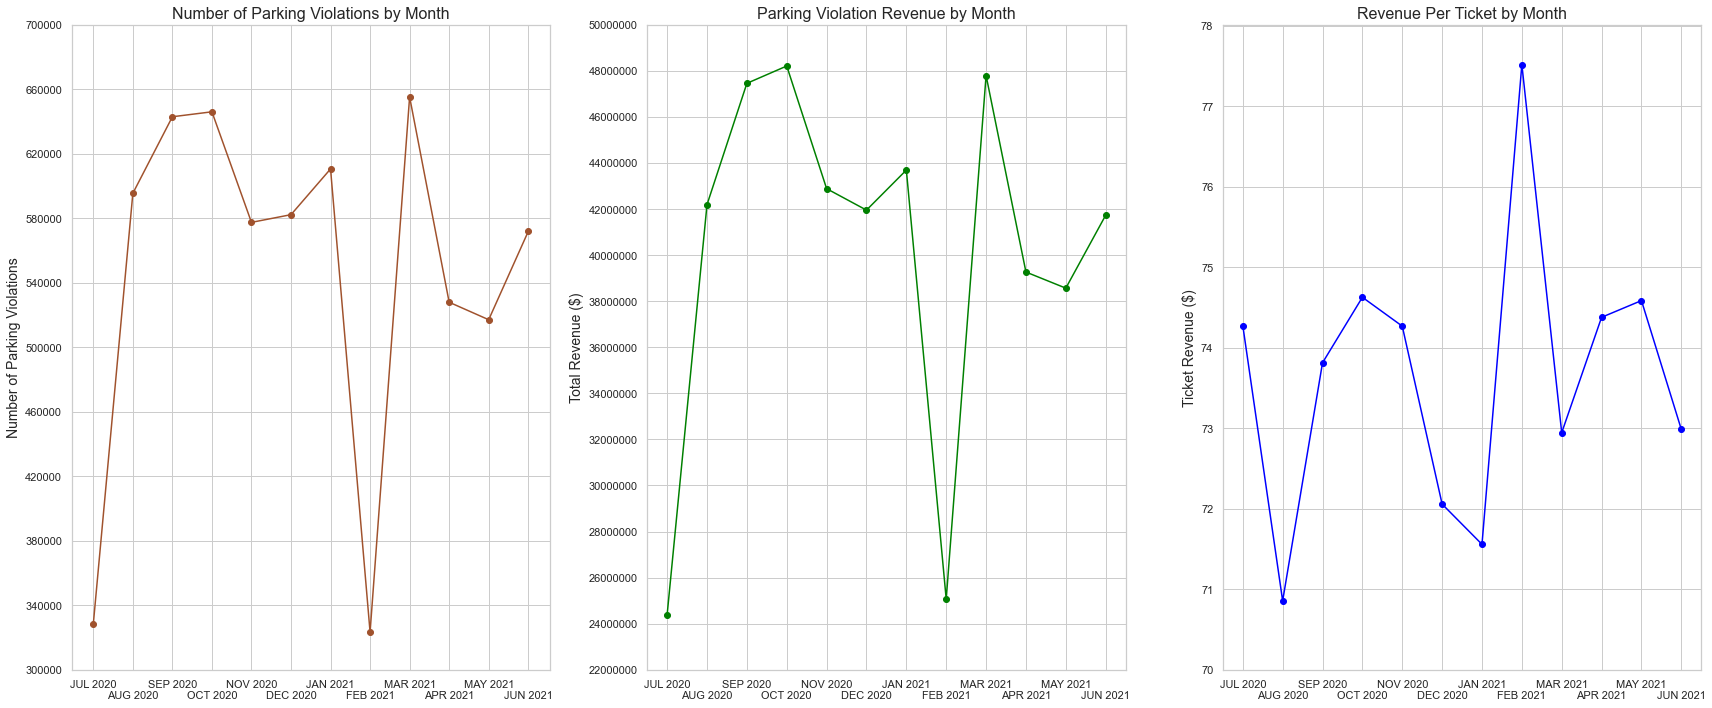

In [3]:
month_year_list = months.index.tolist()
n = len(month_year_list)
x_labels = [('\n' if i % 2 == 1 else '') + month_year_list[i] for i in range(n)]

sns.set(style='whitegrid')
plt.figure(figsize=(24, 10))

# Line chart of count tickets by month

plt.subplot(1,3,1)
plt.plot(x_labels,months.month_year,color='sienna',marker='o')
plt.title('Number of Parking Violations by Month', size = 16)
plt.ylabel('Number of Parking Violations', size = 14)
plt.ylim(300000, 660001)
plt.yticks(np.arange(300000, 700001,40000))

# Line chart of sum fine by month
monthly_rev_sort = df[['issue_date', 'month_year', 'violation_fine']].sort_values('issue_date')
monthly_rev = monthly_rev_sort.groupby(monthly_rev_sort.month_year, sort = False).sum()

plt.subplot(1,3,2)
plt.plot(x_labels,monthly_rev.violation_fine, color='green', marker='o')
plt.ylim(22000000,50000001)
plt.yticks(np.arange(22000000, 50000001, 2000000))
plt.xlim(-0.5,11.5)
plt.title('Parking Violation Revenue by Month', size = 16)
plt.ylabel('Total Revenue ($)', size = 14)
plt.ticklabel_format(axis = 'y', style = 'plain')

# Line chart of mean ticket revenue by month
mean_rev = monthly_rev_sort.groupby(monthly_rev_sort.month_year,sort=False).mean()

plt.subplot(1,3,3)
plt.plot(x_labels,mean_rev.violation_fine, color='blue', marker='o')
plt.ylim(70, 78.01)
plt.yticks(np.arange(70, 79, 1))
plt.xlim(-0.5,11.5)
plt.title('Revenue Per Ticket by Month', size = 16)
plt.ylabel('Ticket Revenue ($)', size = 14)

plt.tight_layout()
plt.show()

March had the most tickets issued (655 K), but was beaten by October in revenue (47.8 M vs. 48.2 M).
<br>
<br> December saw more parking tickets issued than November (582 K vs. 577 K), but its revenue was less than November's (41.9 M vs. 42.9 M).
<br>
<br> Although February was among the least profitable months, earning roughly $12.5 M less than the next lowest, its earnings per ticket were 6% greater than those in March, the second highest earner.
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This trend is consistent throughout the year: The lowest earning months beat out the top performers in revenue per ticket.

In [4]:
print('February Violations and Fines (Top 50% Issued):')
print(df[['violation','violation_fine']][df['month_year'] == 'FEB 2021'].value_counts(normalize=True).head())
print('')
print('March Violation Fine and Frequency (Top 50% Issued):')
print(df[['violation','violation_fine']][df['month_year'] == 'MAR 2021'].value_counts(normalize=True).head())
print('')
print('August Violation Fine and Frequency (Top 50% Issued):')
print(df[['violation','violation_fine']][df['month_year'] == 'AUG 2020'].value_counts(normalize=True).head(3))
print('')
print('July Violation Fine and Frequency (Top 50% Issued):')
print(df[['violation','violation_fine']][df['month_year'] == 'JUL 2020'].value_counts(normalize=True).head(4))

February Violations and Fines (Top 50% Issued):
violation                       violation_fine
FAIL TO DSPLY MUNI METER RECPT  35.0              0.133743
NO STANDING-DAY/TIME LIMITS     115.0             0.107586
NO PARKING-STREET CLEANING      45.0              0.093683
NO PARKING-DAY/TIME LIMITS      60.0              0.087841
FIRE HYDRANT                    115.0             0.081686
dtype: float64

March Violation Fine and Frequency (Top 50% Issued):
violation                       violation_fine
NO PARKING-STREET CLEANING      45.0              0.174469
FAIL TO DSPLY MUNI METER RECPT  35.0              0.107752
INSP. STICKER-EXPIRED/MISSING   65.0              0.099600
NO STANDING-DAY/TIME LIMITS     115.0             0.083982
NO PARKING-DAY/TIME LIMITS      60.0              0.075025
dtype: float64

August Violation Fine and Frequency (Top 50% Issued):
violation                       violation_fine
NO PARKING-STREET CLEANING      45.0              0.250948
FAIL TO DSPLY MUNI METE

### Violations by Borough:

In [5]:
#Organizing total revenue by Borough
overall_group = df[['violation_county', 'violation_fine']].groupby(df.violation_county).sum().sort_values('violation_fine', ascending = False)

#Separate dataset for each Borough
nyc = df[df['violation_county'] == 'MANHATTAN']
bklyn = df[df['violation_county'] == 'BROOKLYN']
queens = df[df['violation_county'] == 'QUEENS']
bronx = df[df['violation_county'] == 'BRONX']
staten = df[df['violation_county'] == 'STATEN ISLAND']

#Revenue by borough sorted by date ascending 
nyc_rev_sort = nyc[['issue_date', 'month_year', 'violation_fine']].sort_values('issue_date')
nyc_rev = nyc_rev_sort.groupby(nyc_rev_sort.month_year, sort = False).sum()

bklyn_rev_sort = bklyn[['issue_date', 'month_year', 'violation_fine']].sort_values('issue_date')
bklyn_rev = bklyn_rev_sort.groupby(bklyn_rev_sort.month_year, sort = False).sum()

queens_rev_sort = queens[['issue_date', 'month_year', 'violation_fine']].sort_values('issue_date')
queens_rev = queens_rev_sort.groupby(queens_rev_sort.month_year, sort = False).sum()

bronx_rev_sort = bronx[['issue_date', 'month_year', 'violation_fine']].sort_values('issue_date')
bronx_rev = bronx_rev_sort.groupby(bronx_rev_sort.month_year, sort = False).sum()

staten_rev_sort = staten[['issue_date', 'month_year', 'violation_fine']].sort_values('issue_date')
staten_rev = staten_rev_sort.groupby(staten_rev_sort.month_year, sort = False).sum()

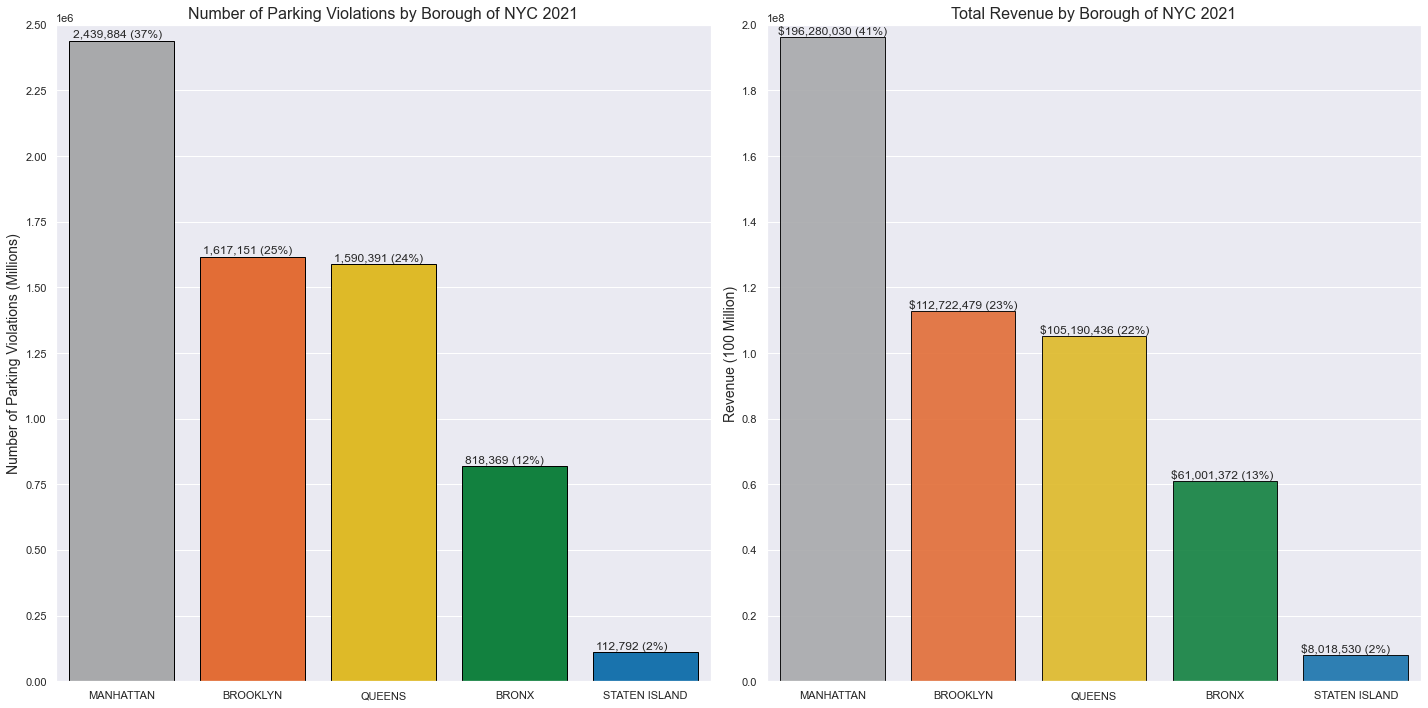

In [6]:
#Number of tickets by borough
boroughs = pd.DataFrame(df.violation_county.value_counts()).sort_values('violation_county', ascending = False)

sns.set_style('darkgrid')
plt.figure(figsize=(20, 10))

plt.subplot(1,2,1)
xvalues = boroughs.index
xvaluerange = range(len(xvalues))

sns.barplot(y=boroughs.violation_county, x=xvalues, palette = ['#A7A9AC', '#FF6319', '#FCCC0A', '#00933C', '#0078C6'], edgecolor='black')
plt.title('Number of Parking Violations by Borough of NYC 2021', size = 16)
plt.ylabel('Number of Parking Violations (Millions)', size = 14)
plt.ylim(0,250000)
plt.yticks(np.arange(0,2500001,250000))
label = ['2,439,884 (37%)','1,617,151 (25%)','1,590,391 (24%)','818,369 (12%)','112,792 (2%)']
for i in xvaluerange:
    plt.text(x = xvaluerange[i] -.375, y = boroughs.violation_county[i]+10000, s = label[i], size = 12)

#Revenue by borough
plt.subplot(1,2,2)
xvalues = overall_group.index
xvaluerange = range(len(xvalues))

sns.barplot(y=overall_group.violation_fine, x=xvalues, palette = ['#A7A9AC', '#FF6319', '#FCCC0A', '#00933C', '#0078C6'], alpha=0.9, edgecolor='black')
plt.title('Total Revenue by Borough of NYC 2021', size = 16)
plt.ylabel('Revenue (100 Million)', size = 14)
plt.ylim(0, 200000001)
plt.yticks(np.arange(0,200000001, 20000000))
plt.xlabel('')
label = ['$196,280,030 (41%)','$112,722,479 (23%)','$105,190,436 (22%)','$61,001,372 (13%)','$8,018,530 (2%)']
for i in xvaluerange:
    plt.text(x = xvaluerange[i] -.415, y = overall_group.violation_fine[i]+900000, s = label[i], size = 12)

plt.tight_layout()
plt.show()

Fun fact: the colors chosen are the official MTA hexcodes for a subway line with a terminal in the corresponding borough!
<br>Staten Island has a lot of private parking available and is not nearly as populated as the other boroughs (roughly 500,000 individuals vs the next biggest, Bronx, at 1.42 million).


In [7]:
print('Percentage of all 2021 parking violations:')
print('Manhattan:', int(round((2439884/6578587),2) * 100),'%')
print('Brooklyn:', int(round((1617151/6578587),2) * 100),'%')
print('Queens:', int(round((1590391/6578587),2) * 100),'%')
print('Bronx:', int(round((818369/6578587),2) * 100),'%')
print('Staten Island:', int(round((112792/6578587),2) * 100),'%')

Percentage of all 2021 parking violations:
Manhattan: 37 %
Brooklyn: 25 %
Queens: 24 %
Bronx: 12 %
Staten Island: 2 %


In [8]:
print('Percentage of total 2021 parking violation revenue:')
print('Manhattan:', int(round((196280030/483212847),2) * 100),'%')
print('Brooklyn:', int(round((112722479/483212847),2) * 100),'%')
print('Queens:', int(round((105190436/483212847),2) * 100),'%')
print('Bronx:', int(round((61001372/483212847),2) * 100),'%')
print('Staten Island:', int(round((8018530/483212847),2) * 100),'%')

Percentage of total 2021 parking violation revenue:
Manhattan: 41 %
Brooklyn: 23 %
Queens: 22 %
Bronx: 13 %
Staten Island: 2 %


Manhattan, making up 37% of all parking violations in NYC, contributes to 41% of total revenue, which makes sense given the slightly increased fines compared to other boroughs (roughly 5% more expensive).
- fine table analysis to show 5% diff

In [9]:
borough_info = {'Borough':['MANHATTAN','BROOKLYN','QUEENS','BRONX','STATEN ISLAND'],
                'population':[1576876, 2641052, 2331143, 1424948, 493494],
                'area_sqmi':[22.83, 70.82, 108.53, 42.10, 58.37],
                'total_revenue':[nyc.violation_fine.sum(), bklyn.violation_fine.sum(), queens.violation_fine.sum(), bronx.violation_fine.sum(), staten.violation_fine.sum()]}
borough_census = pd.DataFrame(borough_info)
borough_census['pop_density'] = (borough_census.population / borough_census.area_sqmi).round(2)
borough_census.sort_values('pop_density', inplace = True)
borough_census

,Borough,population,area_sqmi,total_revenue,pop_density
4,STATEN ISLAND,493494,58.37,8018530.0,8454.58
2,QUEENS,2331143,108.53,105190436.0,21479.25
3,BRONX,1424948,42.10,61001372.0,33846.75
1,BROOKLYN,2641052,70.82,112722479.0,37292.46
0,MANHATTAN,1576876,22.83,196280030.0,69070.35


If population and density were the only variables influencing number of parking violations issued, our borough count distribution would be much more condensed, with Manhattan placing third due to a lower population than Queens and Brooklyn.
<br>We would expect Staten Island to have roughly 30-40 % of the violations that Bronx had. 

Additional variables that may be responsible for our observed distribution include but are not limited to:
- Daily traffic - Manhattan as a destination is far more popular than Staten Island.
- Number of parking spaces available - The lower the density, the more parking spots available. Less parking means more violations such as double parking. 
  - Queens is higher than the Bronx despite a lower population density due to its organization into a few population hot-spots.
- Prevalence of metered parking spaces - Having more meters provides more opportunities for meter violations to occur.

Population data derived from <a href="https://www.census.gov/quickfacts/fact/table/bronxcountynewyork,newyorkcountynewyork,queenscountynewyork,kingscountynewyork,richmondcountynewyork/PST045221"> US Census Bureau </a> calculating density using 2021 population estimates and land area of borough.

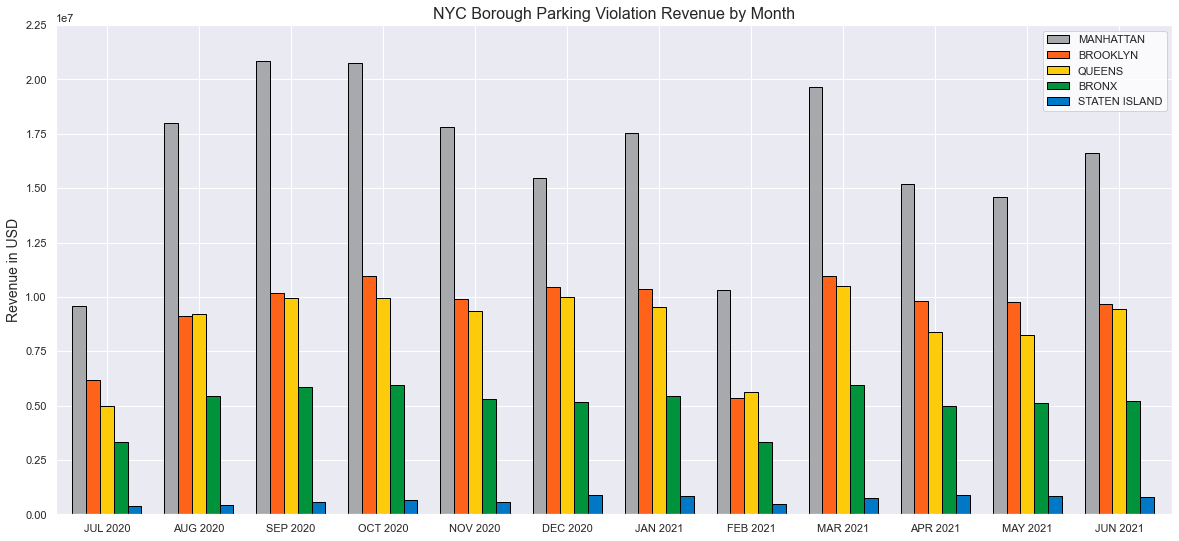

In [10]:
nycrevlst = nyc_rev.violation_fine.tolist()
bklynrevlst = bklyn_rev.violation_fine.tolist()
queensrevlst = queens_rev.violation_fine.tolist()
bronxrevlst = bronx_rev.violation_fine.tolist()
statenrevlst = staten_rev.violation_fine.tolist()

plt.figure(figsize=(20, 9))
barWidth = 0.3

x1coords = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23]   #Manhattan
x2coords = [x + barWidth for x in x1coords]              #Brooklyn
x3coords = [x + barWidth for x in x2coords]              #Queens
x4coords = [x + barWidth for x in x3coords]              #Bronx
x5coords = [x + barWidth for x in x4coords]              #Staten Island

#Separate bars for each borough
plt.bar(x = x1coords, height = nycrevlst, width = barWidth, edgecolor = 'black', color = '#A7A9AC', label = 'MANHATTAN')
plt.bar(x = x2coords, height = bklynrevlst, width = barWidth, edgecolor = 'black', color = '#FF6319', label = 'BROOKLYN')
plt.bar(x = x3coords, height = queensrevlst, width = barWidth, edgecolor = 'black', color = '#FCCC0A', label = 'QUEENS')
plt.bar(x = x4coords, height = bronxrevlst, width = barWidth, edgecolor = 'black', color = '#00933C', label = 'BRONX')
plt.bar(x = x5coords, height = statenrevlst, width = barWidth, edgecolor = 'black', color = '#0078C6', label = 'STATEN ISLAND')

plt.title('NYC Borough Parking Violation Revenue by Month', size = 16)
plt.ylabel('Revenue in USD', size = 14)
plt.legend(facecolor = 'white')
plt.xlim(0.5,24.75)
plt.xticks([r + 2 * barWidth for r in x1coords], staten_rev.index)
plt.ylim(0, 22500001)
plt.yticks(np.arange(0,22500001, 2500000))

plt.show()

February 2021 and July 2020 collected signifigantly lower revenue than other months, which is expected given that these 2 months saw the least amount of tickets given in the year.
<br> A <a href= "https://www.kaggle.com/code/yudanc/2017-nyc-parking-ticket-data-visualization"> similar analysis</a> of 2017 data also found July to have among the least amount of tickets given, but not February: 
- This could be explained by the <a href= "https://www.ny1.com/nyc/all-boroughs/weather/2021/02/26/this-is-why-nyc-will-remember-this-february-s-weather-for-many-years-to-come"> blizzards of February 2021</a> which saw "24 consecutive days with more than an inch of snow on the ground."

I'm not sure about July 2020, however. Maybe related to first month off from school? 
- More car usage:
  - Driving with kids to activities/vacation spots outside of NYC.
  - Teens using parents' cars more frequently.
  
Overall results in cars not staying parked as long.
- Less car usage:
  - Stored in private parking while owner is away from NYC.

In [11]:
#Lists of cumulative revenue by month
nyc_rev_cumulative = []
for i in range(len(nycrevlst)):
    if i == 0:
        nyc_rev_cumulative.append(nycrevlst[i])
    else:
        nyc_rev_cumulative.append(nycrevlst[i] + nyc_rev_cumulative[i-1])

bklyn_rev_cumulative = []
for i in range(len(nycrevlst)):
    if i == 0:
        bklyn_rev_cumulative.append(bklynrevlst[i])
    else:
        bklyn_rev_cumulative.append(bklynrevlst[i] + bklyn_rev_cumulative[i-1])

queens_rev_cumulative = []
for i in range(len(nycrevlst)):
    if i == 0:
        queens_rev_cumulative.append(queensrevlst[i])
    else:
        queens_rev_cumulative.append(queensrevlst[i] + queens_rev_cumulative[i-1])

bronx_rev_cumulative = []        
for i in range(len(nycrevlst)):
    if i == 0:
        bronx_rev_cumulative.append(bronxrevlst[i])
    else:
        bronx_rev_cumulative.append(bronxrevlst[i] + bronx_rev_cumulative[i-1])

staten_rev_cumulative = []
for i in range(len(nycrevlst)):
    if i == 0:
        staten_rev_cumulative.append(statenrevlst[i])
    else:
        staten_rev_cumulative.append(statenrevlst[i] + staten_rev_cumulative[i-1])
        
#I've discovered np.diff()

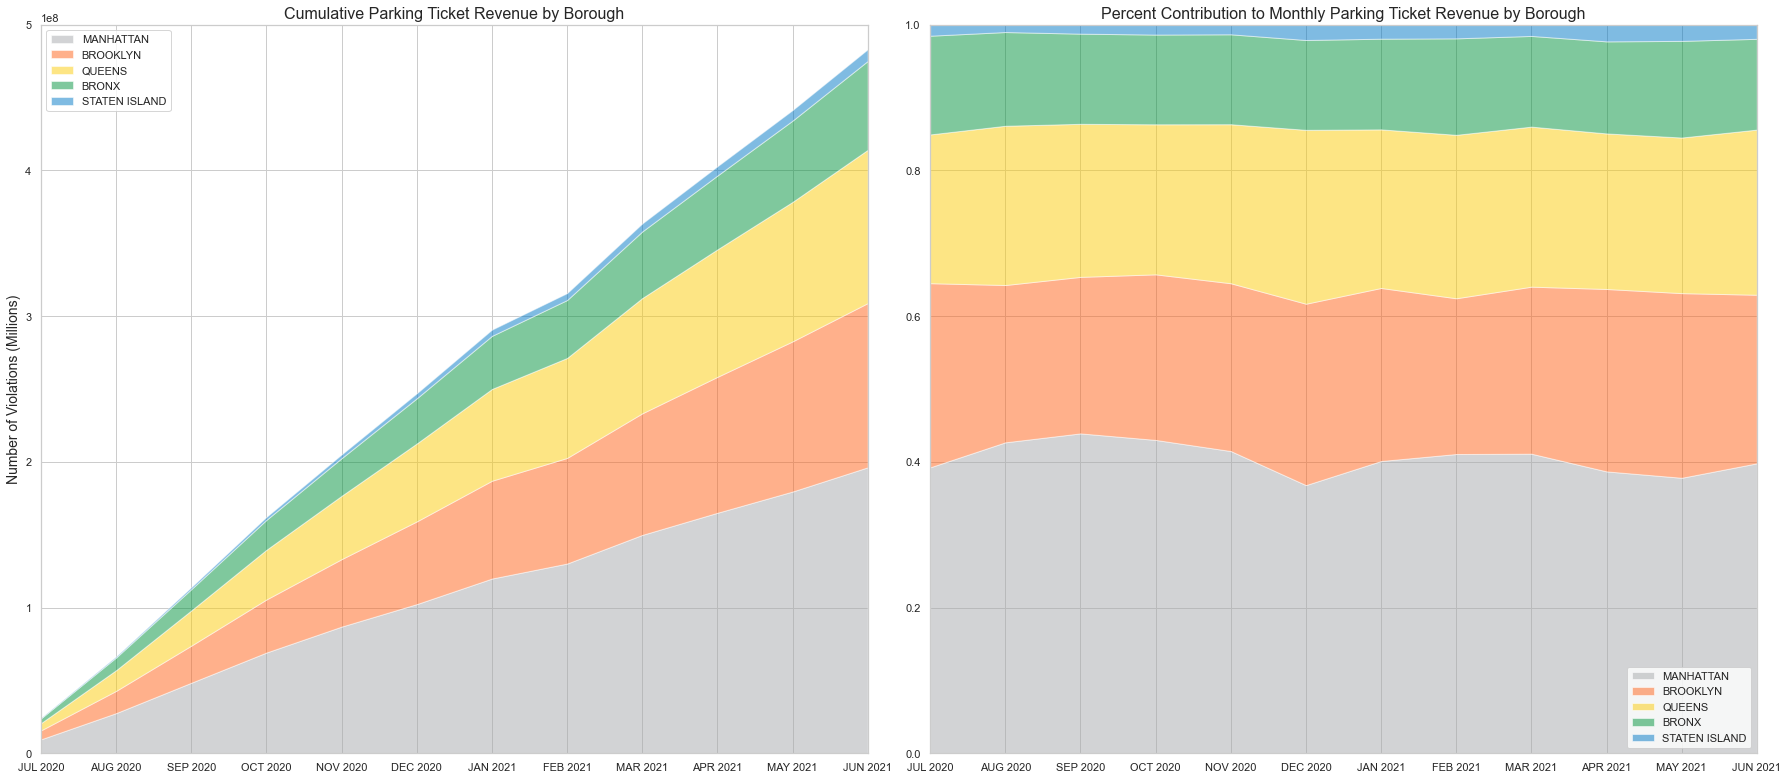

In [12]:
sns.set(style='whitegrid')
plt.figure(figsize=(25, 11))

#Cumulative revenue by borough
monthx = ['JUL 2020', 'AUG 2020', 'SEP 2020', 'OCT 2020', 'NOV 2020', 'DEC 2020', 'JAN 2021', 'FEB 2021', 'MAR 2021', 'APR 2021', 'MAY 2021', 'JUN 2021']
monthy = [nyc_rev_cumulative, bklyn_rev_cumulative, queens_rev_cumulative, bronx_rev_cumulative, staten_rev_cumulative]
palette = ['#A7A9AC','#FF6319','#FCCC0A','#00933C','#0078C6']

plt.subplot(1,2,1)
plt.stackplot(monthx,monthy, labels=['MANHATTAN','BROOKLYN','QUEENS','BRONX','STATEN ISLAND'], colors=palette, alpha=0.5)
plt.legend(loc='upper left',facecolor='white')
plt.title('Cumulative Parking Ticket Revenue by Borough', size=16)
plt.ylabel('Number of Violations (Millions)', size=14)
plt.xlim(0,11)
plt.ylim(0,500000001)

#Revenue by month by borough stacked area chart
revdf = pd.DataFrame({'MANHATTAN':nycrevlst,'BROOKLYN':bklynrevlst,'QUEENS':queensrevlst,'BRONX':bronxrevlst,'STATEN ISLAND':statenrevlst}, index = monthx)
rev_per = revdf.divide(revdf.sum(axis=1), axis=0)

plt.subplot(1,2,2)
plt.stackplot(monthx, rev_per['MANHATTAN'], rev_per['BROOKLYN'], rev_per['QUEENS'], rev_per['BRONX'], rev_per['STATEN ISLAND'], labels=['MANHATTAN','BROOKLYN','QUEENS','BRONX','STATEN ISLAND'], colors=palette, alpha=0.5)
plt.margins(0,0)
plt.title('Percent Contribution to Monthly Parking Ticket Revenue by Borough', size=16)
plt.legend(loc='lower right', facecolor = 'white')

plt.tight_layout()
plt.show()

% contribution by borough looks to be mostly consistent throughout the year.
<br> Interestingly, Bronx % contribution was at its highest during the 3 worst earning months (Jul, Feb, and May):
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;While the other boroughs saw decreases in revenue of over 41% in February, the Bronx's revenue only decreased by 38%

In [13]:
print('Percent Contribution to Monthly Parking Ticket Revenue by Borough:')
print(rev_per)

Percent Contribution to Monthly Parking Ticket Revenue by Borough:
          MANHATTAN  BROOKLYN    QUEENS     BRONX  STATEN ISLAND
JUL 2020   0.392510  0.252838  0.204163  0.135512       0.014977
AUG 2020   0.426864  0.215946  0.218601  0.128655       0.009935
SEP 2020   0.439137  0.214851  0.210081  0.123780       0.012151
OCT 2020   0.430171  0.227300  0.205948  0.123166       0.013415
NOV 2020   0.414906  0.230357  0.218269  0.123434       0.013034
DEC 2020   0.368146  0.248996  0.238670  0.123323       0.020865
JAN 2021   0.401227  0.237552  0.217676  0.124481       0.019064
FEB 2021   0.410808  0.213821  0.224349  0.132425       0.018597
MAR 2021   0.411261  0.229297  0.219658  0.124510       0.015274
APR 2021   0.386973  0.250402  0.213514  0.126373       0.022739
MAY 2021   0.378208  0.253473  0.213579  0.132653       0.022086
JUN 2021   0.398049  0.231414  0.226693  0.124614       0.019231


In [14]:
#Overall percent change by month
totalh = df[['issue_date', 'month_year', 'violation_fine']].sort_values('issue_date')
totalh = totalh.groupby(totalh.month_year, sort = False).sum()
totalh_pct = pd.DataFrame(totalh)

totalpctlist = []
for i in range(len(totalh_pct)):
    if i == 0:
        totalpctlist.append(0)
    else:
        totalpctlist.append((totalh_pct.violation_fine[i] - totalh_pct.violation_fine[i-1])/totalh_pct.violation_fine[i])
totalh_pct['percent_change'] = totalpctlist
totalh_pct['percent_change'] = (totalh_pct['percent_change'] * 100).round(2)

#Manhattan pct change
nycpctlist = []
for i in range(len(nycrevlst)):
    if i == 0:
        nycpctlist.append(0)
    else:
        nycpctlist.append((nycrevlst[i] - nycrevlst[i-1])/nycrevlst[i])
nyc_rev['percent_change'] = nycpctlist
nyc_rev['percent_change'] = (nyc_rev['percent_change'] * 100).round(2)

#Brooklyn pct change
bklynpctlist = []
for i in range(len(bklynrevlst)):
    if i == 0:
        bklynpctlist.append(0)
    else:
        bklynpctlist.append((bklynrevlst[i] - bklynrevlst[i-1])/bklynrevlst[i])
bklyn_rev['percent_change'] = bklynpctlist
bklyn_rev['percent_change'] = (bklyn_rev['percent_change'] * 100).round(2)

#Queens pct change
queenspctlist = []
for i in range(len(queensrevlst)):
    if i == 0:
        queenspctlist.append(0)
    else:
        queenspctlist.append((queensrevlst[i] - queensrevlst[i-1])/queensrevlst[i])
queens_rev['percent_change'] = queenspctlist
queens_rev['percent_change'] = (queens_rev['percent_change'] * 100).round(2)

#Bronx pct change
bronxpctlist = []
for i in range(len(bronxrevlst)):
    if i == 0:
        bronxpctlist.append(0)
    else:
        bronxpctlist.append((bronxrevlst[i] - bronxrevlst[i-1])/bronxrevlst[i])
bronx_rev['percent_change'] = bronxpctlist
bronx_rev['percent_change'] = (bronx_rev['percent_change'] * 100).round(2)

#Statenisland pct change
statenpctlist = []
for i in range(len(statenrevlst)):
    if i == 0:
        statenpctlist.append(0)
    else:
        statenpctlist.append((statenrevlst[i] - statenrevlst[i-1])/statenrevlst[i])
staten_rev['percent_change'] = statenpctlist
staten_rev['percent_change'] = (staten_rev['percent_change'] * 100).round(2)

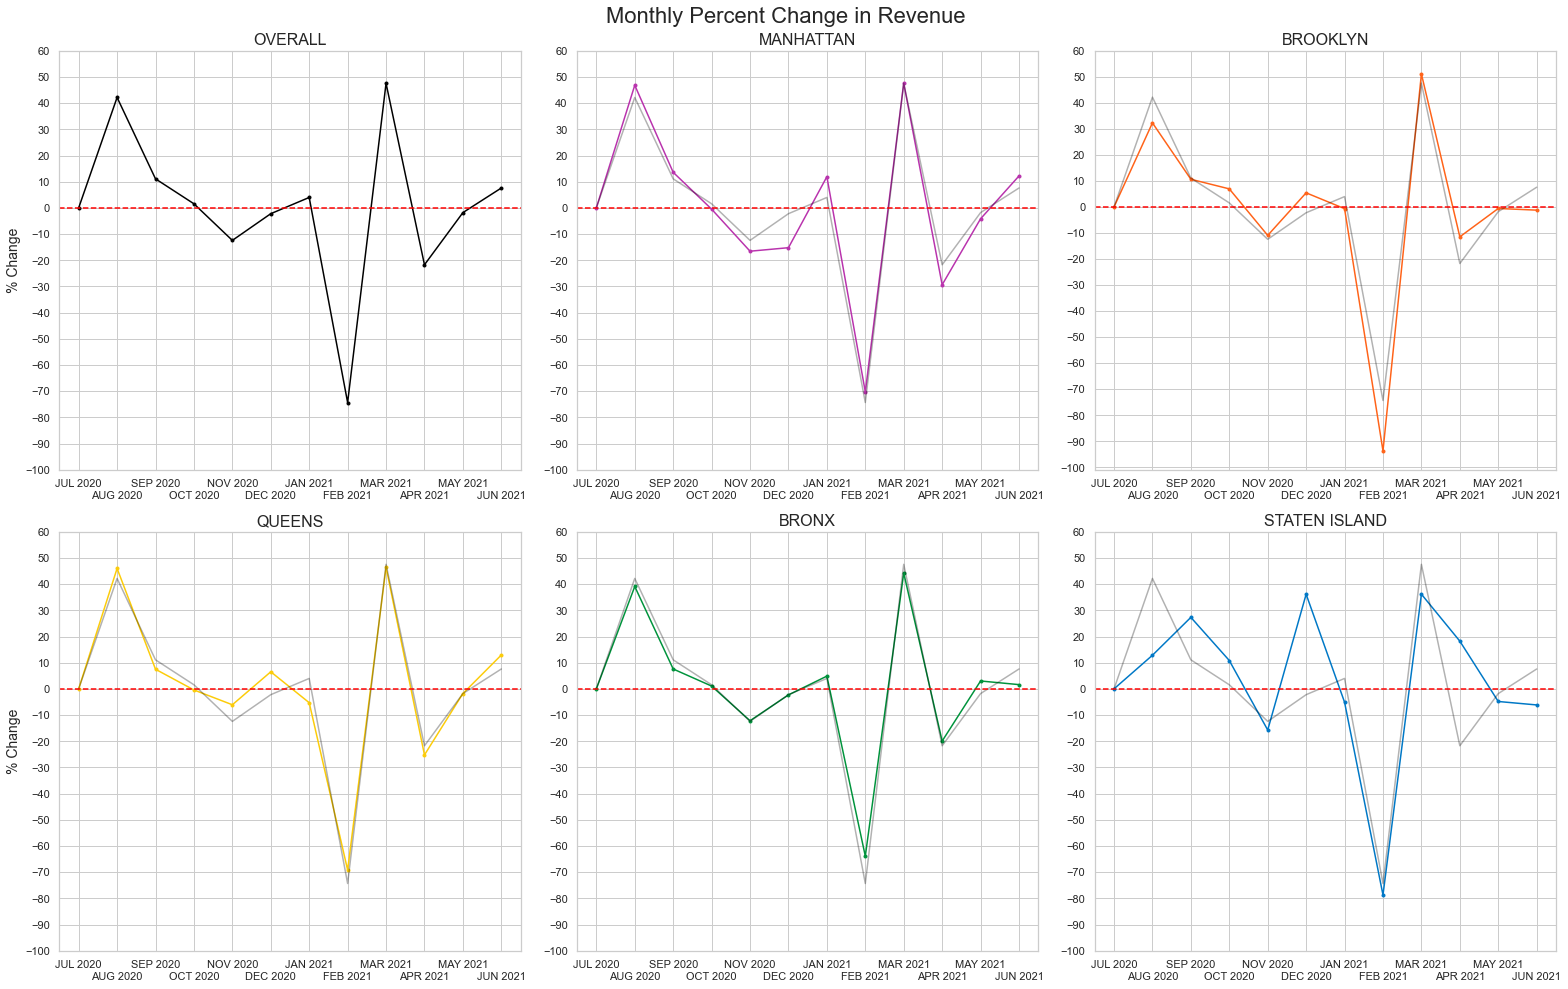

In [15]:
sns.set(style='whitegrid')
plt.figure(figsize=(22, 14))

#Overall
plt.subplot(2,3,1)

plt.plot(x_labels,totalh_pct.percent_change, color='black', marker='.')
plt.xlim(-0.5,11.5)
plt.yticks(np.arange(-100, 60.0000001, 10))
plt.title('OVERALL', size = 16)
plt.ylabel('% Change', size = 14)
plt.axhline(y=0, color='red', ls='--')

#NYC
plt.subplot(2,3,2)

plt.plot(x_labels,nyc_rev.percent_change, color='#B933AD', marker='.')

#Overall line overlay
plt.plot(x_labels,totalh_pct.percent_change, color='black',alpha=0.3)

plt.xlim(-0.5,11.5)
plt.yticks(np.arange(-100, 60.0000001, 10))
plt.title('MANHATTAN', size = 16)
plt.axhline(y=0, color='red', ls='--')

#Brooklyn
plt.subplot(2,3,3)

plt.plot(x_labels,bklyn_rev.percent_change, color='#FF6319', marker='.')

plt.plot(x_labels,totalh_pct.percent_change, color='black',alpha=0.3)

plt.xlim(-0.5,11.5)
plt.yticks(np.arange(-100, 60.0000001, 10))
plt.title('BROOKLYN', size = 16)
plt.axhline(y=0, color='red', ls='--')

#Queens
plt.subplot(2,3,4)

plt.plot(x_labels,queens_rev.percent_change, color='#FCCC0A', marker='.')

plt.plot(x_labels,totalh_pct.percent_change, color='black',alpha=0.3)

plt.xlim(-0.5,11.5)
plt.yticks(np.arange(-100, 60.0000001, 10))
plt.title('QUEENS', size = 16)
plt.ylabel('% Change', size = 14)
plt.axhline(y=0, color='red', ls='--')

#Bronx
plt.subplot(2,3,5)

plt.plot(x_labels,bronx_rev.percent_change, color='#00933C', marker='.')

plt.plot(x_labels,totalh_pct.percent_change, color='black', alpha=0.3)

plt.xlim(-0.5,11.5)
plt.yticks(np.arange(-100, 60.0000001, 10))
plt.title('BRONX', size = 16)
plt.axhline(y=0, color='red', ls='--')

#Staten Island
plt.subplot(2,3,6)

plt.plot(x_labels,staten_rev.percent_change, color='#0078C6',marker='.')

plt.plot(x_labels,totalh_pct.percent_change, color='black', alpha=0.3)

plt.xlim(-0.5,11.5)
plt.title('STATEN ISLAND', size = 16)
plt.axhline(y=0, color='red', ls='--')
plt.yticks(np.arange(-100, 60.0000001, 10))

#Experimenting with area filling for positives and negatives:
#plt.fill_between(x_labels, statenh_rev.percent_change, where=(staten_rev.percent_change < 0), 
#                 color='r',alpha=0.3,interpolate=True)
#plt.fill_between(x_labels, statenh_rev.percent_change, where=(statenh_rev.percent_change > 0), 
#                 color='g',alpha=0.3,interpolate=True)

plt.suptitle('Monthly Percent Change in Revenue',size=22)

plt.tight_layout()
plt.show()

The boroughs are relatively in line with the overall trend during the February dip, with the exception of the Bronx and Brooklyn.
<br>The snowstorm impacted Brooklyn's parking ticket revenue much more heavily than the rest of NYC, whereas the Bronx was least impacted. 

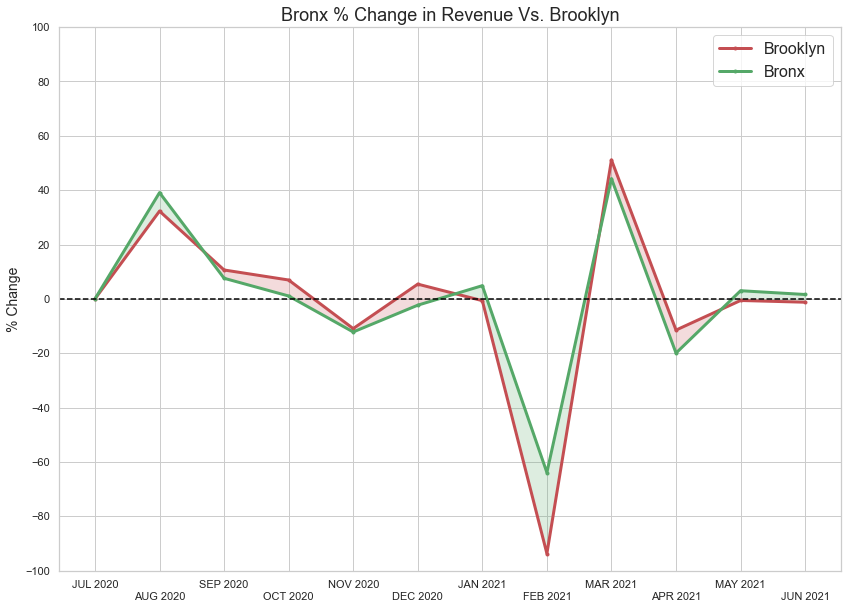

In [16]:
plt.figure(figsize=(14, 10))
sns.set(style='whitegrid')

plt.plot(x_labels,bklyn_rev.percent_change, color='r', marker='.', label='Brooklyn',lw=3)
plt.plot(x_labels,bronx_rev.percent_change, color='g', marker='.', label='Bronx',lw=3)
plt.axhline(y=0, color='black', ls='--')
plt.title('Bronx % Change in Revenue Vs. Brooklyn', size=18)
plt.ylabel('% Change',size=14)
plt.legend(fontsize=16)
plt.fill_between(x_labels, bronx_rev.percent_change, bklyn_rev.percent_change, where=(bronx_rev.percent_change > bklyn_rev.percent_change), 
                color='g',alpha=0.2,interpolate=True)
plt.fill_between(x_labels, bronx_rev.percent_change, bklyn_rev.percent_change, where=(bronx_rev.percent_change < bklyn_rev.percent_change), 
                color='r',alpha=0.2,interpolate=True)
plt.ylim(-100,100.0000001)
plt.yticks(np.arange(-100, 100.0000001, 20))

plt.show()

### Parking Violations by Day:

##### Calendar Heatmap - Derived from <a href='https://github.com/martijnvermaat/calmap/tree/master/calmap'> calmap</a>. 
##### I modified the source code to accomodate data organized by NYC fiscal year rather than calendar year.

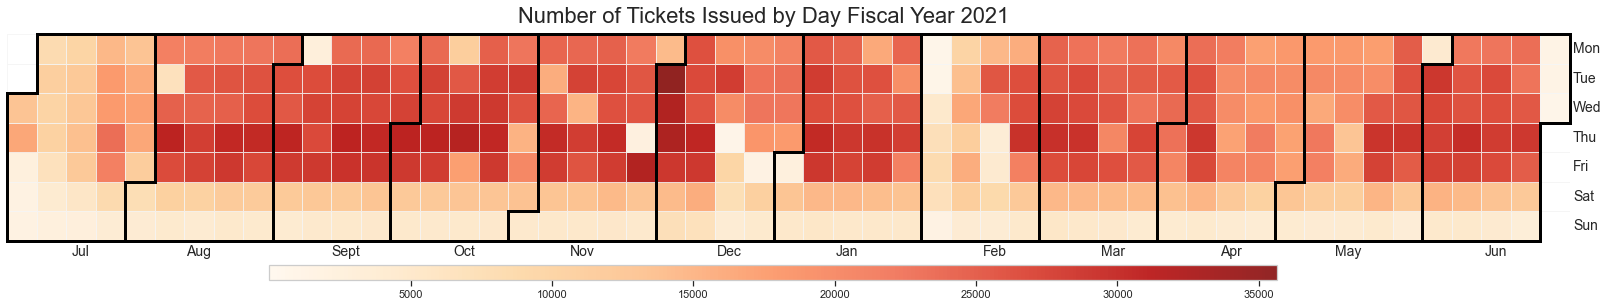

In [18]:
daylabels=calendar.day_abbr[:]

# Organizing date count data into pivot

alldaysdf = pd.Series(df.issue_date.value_counts())
alldaysdf.index = pd.to_datetime(alldaysdf.index)
alldaysdf = alldaysdf.reindex(
        pd.date_range(start='7/1/2020', end='7/1/2021', freq='D')[:-1])

vmin = alldaysdf.min()
vmax = alldaysdf.max()

alldaysdf = pd.DataFrame({'data': alldaysdf,
                           'fill': 1,
                           'day': alldaysdf.index.weekday,
                           'week': alldaysdf.index.isocalendar().week})
alldaysdf.loc['2020-07-01':'2021-01-03', 'week'] =  (alldaysdf.loc['2020-07-01':'2021-01-03', 'week'] - 26)
alldaysdf.loc['2021-01-04':, 'week'] =  (alldaysdf.loc['2021-01-04':, 'week'] + 27)

plot_data = alldaysdf.pivot('day', 'week', 'data').values[::-1]
plot_data = np.ma.masked_where(np.isnan(plot_data), plot_data)

# Filling nan values with alldaysdf.fill

fill_data = alldaysdf.pivot('day', 'week', 'fill').values[::-1]
fill_data = np.ma.masked_where(np.isnan(fill_data), fill_data)

# Heatmap plotting
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(28,3.8))

ax.grid(False)
ax.pcolormesh(fill_data, vmin=0, vmax=1, color='white') # Nan color
ax.pcolormesh(plot_data, vmin=vmin, vmax=vmax, cmap='OrRd', edgecolors='whitesmoke', alpha=0.85, linewidth=1)  # Heatmap color scheme
ax.set(xlim=(0, plot_data.shape[1]), ylim=(0, plot_data.shape[0])) 
ax.set_aspect('equal', adjustable='box')  # Rectangles with 4 equal sides (squares)

for side in ('top', 'right', 'left', 'bottom'):
    ax.spines[side].set_visible(False)
ax.xaxis.set_tick_params(which='both', length=0)
ax.yaxis.set_tick_params(which='both', length=0)

# Ticks and labels

monthticks = range(12)
dayticks = range(len(daylabels))

xticklist = []
for date in alldaysdf.index:
    if '15' in str(date):
        xticklist.append(((alldaysdf.loc[date, 'week']) - 0.5))
ax.set_xlabel('')
ax.set_xticks(xticklist)
ax.set_xticklabels(['Jul','Aug','Sept','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun'], ha='center', size=14)

ax.set_ylabel('')
ax.yaxis.set_ticks_position('right')
ax.set_yticks([(6 - i + 0.5) for i in dayticks])
ax.set_yticklabels([daylabels[i] for i in dayticks], rotation='horizontal', va='center', size=14)

# Month borders modified from https://github.com/rougier/calendar-heatmap

for month in range(1,13):
    if month >=7:
        start = dt(2020, 7, 1).weekday()
        first = dt(2020, month, 1)
        last = first + relativedelta(months=1, days=-1)
        y0 = 7 - first.weekday()                          # Upper y of first day in month
        y1 = 7 - last.weekday()                           # Upper y of last day in month
        x0 = (int(first.strftime('%j'))+start-1)//7       # Left x of first week
        x1 = (int(last.strftime('%j'))+start-1)//7        # Left x of last week
        P = [(x0-26, y0),   # Upper left corner of first day
             (x0-25, y0),   # Upper right corner of first day
             (x0-25, 7),    # 2nd week upper left corner
             (x1-25, 7),    # Last week upper right corner
             (x1-25, y1-1), # Lower right corner of last day
             (x1-26, y1-1), # Lower left corner of last day
             (x1-26, 0),    # Lower left corner of last week
             (x0-26, 0) ]   # Lower left corner of first week 
        poly = Polygon(P, edgecolor='black', facecolor='none',
                           linewidth=3, zorder=20, clip_on=False)
        ax.add_artist(poly)
    else:
        start = dt(2021, 1, 1).weekday()                  
        first = dt(2021, month, 1)
        last = first + relativedelta(months=1, days=-1)
        y0 = 7 - first.weekday()                          # Upper y of first day in month
        y1 = 7 - last.weekday()                           # Upper y of last day in month
        x0 = (int(first.strftime('%j'))+start-1)//7       # left x of first week
        x1 = (int(last.strftime('%j'))+start-1)//7        # left x of last week
        P = [(x0+26, y0),   # Upper left corner of first day
             (x0+27, y0),   # Upper right corner of first day
             (x0+27, 7),    # 2nd week upper left corner
             (x1+27, 7),    # Last week upper right corner
             (x1+27, y1-1), # Lower right corner of last day
             (x1+26, y1-1), # Lower left corner of last day
             (x1+26, 0),    # Lower left corner of last week
             (x0+26, 0) ]   # Lower left corner of first week
        poly = Polygon(P, edgecolor='black', facecolor='none',
                           linewidth=3, zorder=20, clip_on=False)
        ax.add_artist(poly)


cax = fig.add_axes([0.255, -0.02, 0.5, 0.055])
plt.grid(False)
plt.colorbar(ax.get_children()[1], cax=cax, orientation='horizontal')
plt.suptitle('Number of Tickets Issued by Day Fiscal Year 2021', size=22)

plt.show()

#### Weekdays with the least amount of tickets given:
- Dec 17, Feb 1, Feb 18 - Snowstorms
- Jul 6 - COVID <a href='https://www.investopedia.com/historical-timeline-of-covid-19-in-new-york-city-5071986'> Phase 3 reopening</a>.
- Jul 22 - COVID Phase 4 reopening. 
   - Squares start getting progressively darker after phase 3 and much darker following phase 4
   - There is more evidence for this explaination of lower revenue in July than earlier suggestion of school closings.
- Aug 4 - Hurricane Isaias

#### Weekdays with the most tickets given:
- Thursdays overall - Are there more drivers around/deliveries being made on Thursdays?
- Dec 1 - 35,651 tickets, 11,779 (33%) of which were for missing/expired inspection stickers - Holiday Shopping
- Dec 2 - 32,739 tickets
- Dec 3 - 32,314 tickets
- Nov 27 - 32,249 tickets - Black Friday
- Oct 15 - 3rd most profitable day - 31,873


### Each Month's Revenue by Day:
Red indicates least profitable month, while green indicates most profitable.

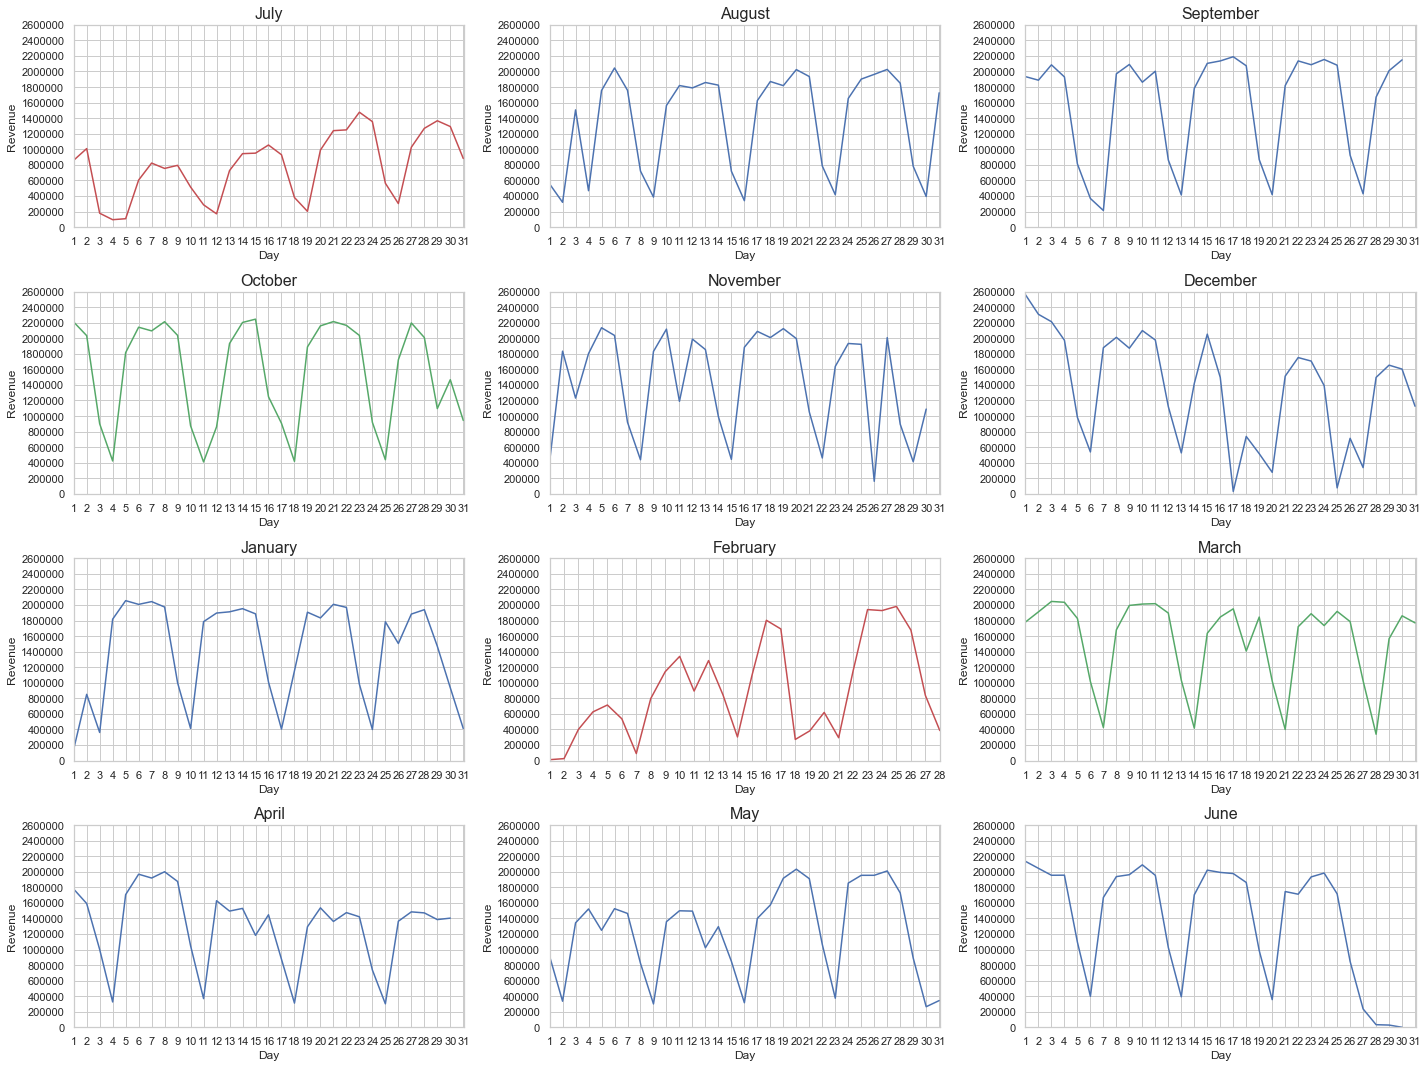

In [20]:
febdays= range(1,29)
thirtydays= range(1,31)
thirtyonedays= range(1,32)

sns.set(style='whitegrid')

plt.figure(figsize=(20,15))

plt.subplot(4,3,1)

jul = df[['issue_date', 'violation_fine']][df['month_year'] == 'JUL 2020']
jul_days = jul.groupby('issue_date').sum()

plt.plot(thirtyonedays, jul_days.violation_fine,color='r')
plt.title('July', size=16)
plt.xticks(np.arange(1,31.1))
plt.xlim(1,31.05)
plt.xlabel('Day', size=12)
plt.ylabel('Revenue')
plt.yticks(np.arange(0,2600100, 200000))
plt.ylim(0, 2600100)

plt.ticklabel_format(style='plain',axis='y')

plt.subplot(4,3,2)

aug = df[['issue_date', 'violation_fine']][df['month_year'] == 'AUG 2020']
aug_days = aug.groupby('issue_date').sum()

plt.plot(thirtyonedays, aug_days.violation_fine,color='b')
plt.title('August', size=16)
plt.xticks(np.arange(1,31.1))
plt.xlim(1,31.05)
plt.xlabel('Day', size=12)
plt.ylabel('Revenue')
plt.yticks(np.arange(0,2600100, 200000))
plt.ylim(0, 2600100)

plt.ticklabel_format(style='plain',axis='y')

plt.subplot(4,3,3)

sep = df[['issue_date', 'violation_fine']][df['month_year'] == 'SEP 2020']
sep_days = sep.groupby('issue_date').sum()

plt.plot(thirtydays, sep_days.violation_fine,color='b')
plt.title('September', size=16)
plt.xticks(np.arange(1,31.1))
plt.xlim(1,31.05)
plt.xlabel('Day', size=12)
plt.ylabel('Revenue')
plt.yticks(np.arange(0,2600100, 200000))
plt.ylim(0, 2600100)

plt.ticklabel_format(style='plain',axis='y')

plt.subplot(4,3,4)

october = df[['issue_date', 'violation_fine']][df['month_year'] == 'OCT 2020']
oct_days = october.groupby('issue_date').sum()

plt.plot(thirtyonedays, oct_days.violation_fine,color='g')
plt.title('October', size=16)
plt.xticks(np.arange(1,31.1))
plt.xlim(1,31.05)
plt.xlabel('Day', size=12)
plt.ylabel('Revenue')
plt.yticks(np.arange(0,2600100, 200000))
plt.ylim(0, 2600100)

plt.ticklabel_format(style='plain',axis='y')

plt.subplot(4,3,5)

nov = df[['issue_date', 'violation_fine']][df['month_year'] == 'NOV 2020']
nov_days = nov.groupby('issue_date').sum()

plt.plot(thirtydays, nov_days.violation_fine,color='b')
plt.title('November', size=16)
plt.xticks(np.arange(1,31.1))
plt.xlim(1,31.05)
plt.xlabel('Day', size=12)
plt.ylabel('Revenue')
plt.yticks(np.arange(0,2600100, 200000))
plt.ylim(0, 2600100)

plt.ticklabel_format(style='plain',axis='y')

plt.subplot(4,3,6)

dec = df[['issue_date', 'violation_fine']][df['month_year'] == 'DEC 2020']
dec_days = dec.groupby('issue_date').sum()

plt.plot(thirtyonedays, dec_days.violation_fine,color='b')
plt.title('December', size=16)
plt.xticks(np.arange(1,31.1))
plt.xlim(1,31.05)
plt.xlabel('Day', size=12)
plt.ylabel('Revenue')
plt.yticks(np.arange(0,2600100, 200000))
plt.ylim(0,2600100)

plt.ticklabel_format(style='plain',axis='y')

plt.subplot(4,3,7)

jan = df[['issue_date', 'violation_fine']][df['month_year'] == 'JAN 2021']
jan_days = jan.groupby('issue_date').sum()

plt.plot(thirtyonedays, jan_days.violation_fine,color='b')
plt.title('January', size=16)
plt.xticks(np.arange(1,31.1))
plt.xlim(1,31.05)
plt.xlabel('Day', size=12)
plt.ylabel('Revenue')
plt.yticks(np.arange(0,2600100, 200000))
plt.ylim(0, 2600100)

plt.ticklabel_format(style='plain',axis='y')

plt.subplot(4,3,8)

feb = df[['issue_date', 'violation_fine']][df['month_year'] == 'FEB 2021']
feb_days = feb.groupby('issue_date').sum()

plt.plot(febdays, feb_days.violation_fine, color='r')
plt.title('February',size=16)
plt.xticks(np.arange(1,28.1))
plt.yticks(np.arange(0,2600100, 200000))
plt.ylim(0, 2600100)
plt.ylabel('Revenue')
plt.xlim(1,28)
plt.xlabel('Day', size=12)

plt.ticklabel_format(style='plain',axis='y')

plt.subplot(4,3,9)

mar = df[['issue_date', 'violation_fine']][df['month_year'] == 'MAR 2021']
mar_days = mar.groupby('issue_date').sum()

plt.plot(thirtyonedays, mar_days.violation_fine,color='g')
plt.title('March', size=16)
plt.xticks(np.arange(1,31.1))
plt.xlim(1,31.05)
plt.xlabel('Day', size=12)
plt.ylabel('Revenue')
plt.yticks(np.arange(0,2600100, 200000))
plt.ylim(0, 2600100)

plt.ticklabel_format(style='plain',axis='y')

plt.subplot(4,3,10)

apr = df[['issue_date', 'violation_fine']][df['month_year'] == 'APR 2021']
apr_days = apr.groupby('issue_date').sum()

plt.plot(thirtydays, apr_days.violation_fine,color='b')
plt.title('April', size=16)
plt.xticks(np.arange(1,31.1))
plt.xlim(1,31.05)
plt.xlabel('Day', size=12)
plt.ylabel('Revenue')
plt.yticks(np.arange(0,2600100, 200000))
plt.ylim(0, 2600100)

plt.ticklabel_format(style='plain',axis='y')

plt.subplot(4,3,11)

may = df[['issue_date', 'violation_fine']][df['month_year'] == 'MAY 2021']
may_days = may.groupby('issue_date').sum()

plt.plot(thirtyonedays, may_days.violation_fine,color='b')
plt.title('May', size=16)
plt.xticks(np.arange(1,31.1))
plt.xlim(1,31.05)
plt.xlabel('Day', size=12)
plt.ylabel('Revenue')
plt.yticks(np.arange(0,2600100, 200000))
plt.ylim(0, 2600100)

plt.ticklabel_format(style='plain',axis='y')

plt.subplot(4,3,12)

jun = df[['issue_date', 'violation_fine']][df['month_year'] == 'JUN 2021']
jun_days = jun.groupby('issue_date').sum()

plt.plot(thirtydays, jun_days.violation_fine,color='b')
plt.title('June', size=16)
plt.xticks(np.arange(1,31.1))
plt.xlim(1,31.05)
plt.xlabel('Day', size=12)
plt.ylabel('Revenue')
plt.yticks(np.arange(0,2600100, 200000))
plt.ylim(0, 2600100)


plt.ticklabel_format(style='plain',axis='y')

plt.tight_layout()
plt.show()

### Revenue by Population Density:

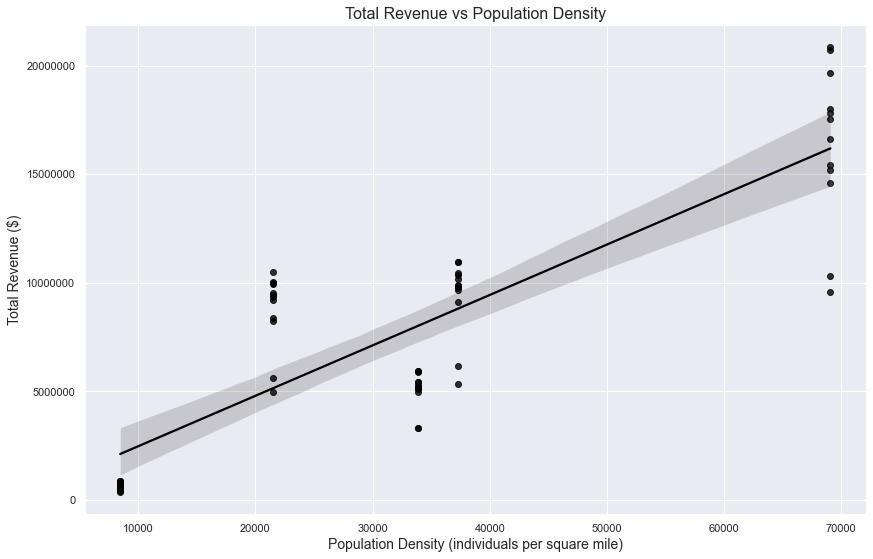

In [22]:
xvalues = all_dens_rev.pop_density
yvalues = all_dens_rev.violation_fine

sns.set_style("darkgrid")

plt.figure(figsize=(14, 9))
sns.regplot(x=xvalues,y=yvalues,color='black')
plt.title('Total Revenue vs Population Density', size = 16)
plt.ylabel('Total Revenue ($)', size = 14)
plt.xlabel('Population Density (individuals per square mile)', size=14)
plt.ticklabel_format(axis = 'y', style = 'plain')

plt.show()

This visualization could be further improved by using population density from each distinct precinct zone.
<br> As population density increases, so does parking ticket revenue. More cars = more tickets.

### Violation Types:

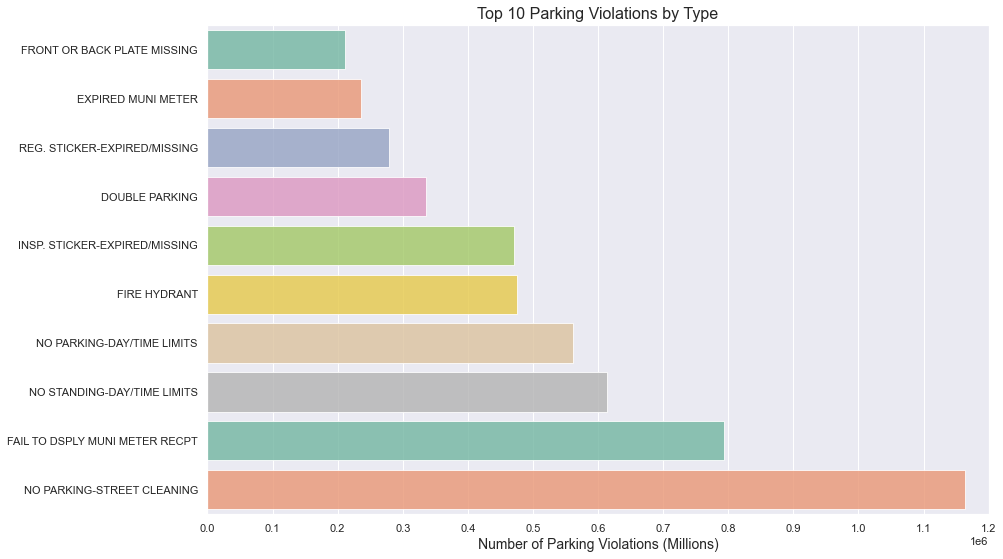

In [23]:
violations = pd.DataFrame(df.violation.value_counts().head(10)).sort_values('violation')
yvalues = violations.index

plt.figure(figsize=(14, 9))

sns.barplot(x=violations.violation, y=yvalues, palette='Set2', alpha = 0.8)
plt.title('Top 10 Parking Violations by Type', size = 16)
plt.xlabel('Number of Parking Violations (Millions)', size = 14)
plt.xlim(0,1200001)
plt.xticks(np.arange(0,1200001, 100000))
plt.show()

#### Hierarchal Bubble Plots for Violation Type in Each Borough

The bubble plots below display top 10 violations for every borough but Staten Island, where the labels became incomprehensible due to size difference.
<br> Thanks to <a href="https://www.yan-holtz.com"> Yan Holtz</a> for his <a href="https://python-graph-gallery.com/circular-packing-several-levels-of-hierarchy"> tutorial</a>!

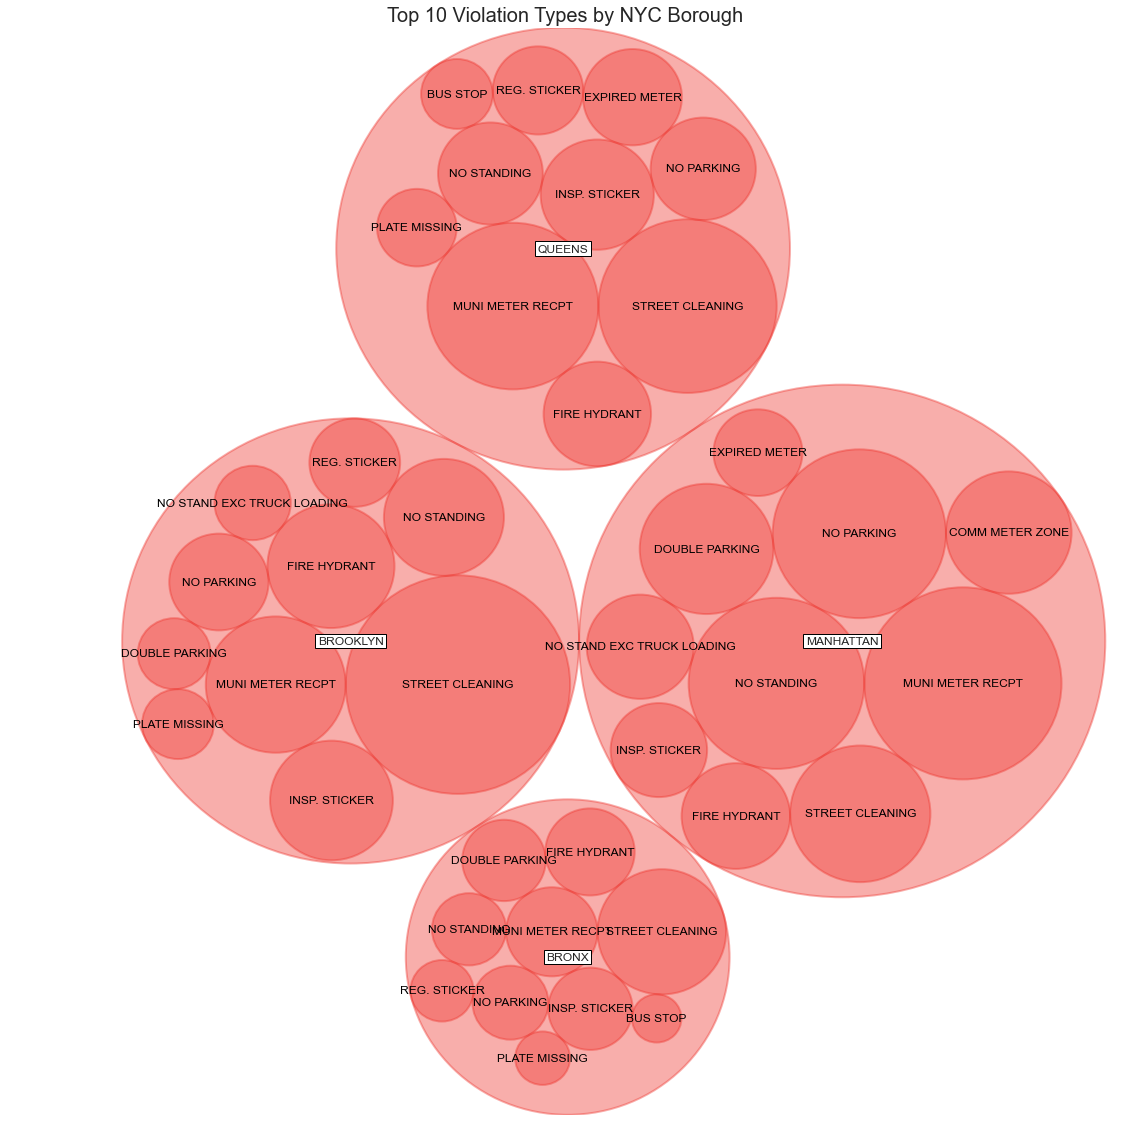

In [25]:
borough_types = [{'id': 'NYC', 'datum': 6578587, 'children' : [
              {'id' : "MANHATTAN", 'datum': 1877117,
                   'children' : [
                     {'id' : "NO STANDING", 'datum' : 299224},
                     {'id' : "NO PARKING", 'datum' : 291177},
                     {'id' : "MUNI METER RECPT", 'datum' : 377110},
                     {'id' : "STREET CLEANING", 'datum' : 190764},
                     {'id' : "EXPIRED METER", 'datum' : 76753},
                     {'id' : "COMM METER ZONE", 'datum' : 153005},
                     {'id' : "FIRE HYDRANT", 'datum' : 114264},
                     {'id' : "NO STAND EXC TRUCK LOADING", 'datum' : 111117},
                     {'id' : "INSP. STICKER", 'datum' : 90321},
                     {'id' : "DOUBLE PARKING", 'datum' : 173382}
                   ]},
              {'id' : "BROOKLYN", 'datum' : 1415581, 
                   'children' : [
                     {'id' : "STREET CLEANING", 'datum' : 475272},
                     {'id' : "MUNI METER RECPT", 'datum' : 184788},
                     {'id' : "FIRE HYDRANT", 'datum' : 152437},
                     {'id' : "INSP. STICKER", 'datum' : 142359},
                     {'id' : "NO STANDING", 'datum' : 135980},
                     {'id' : "NO PARKING", 'datum' : 93161},
                     {'id' : "REG. STICKER", 'datum' : 77731},
                     {'id' : "NO STAND EXC TRUCK LOADING", 'datum' : 55045},
                     {'id' : "DOUBLE PARKING", 'datum' : 50176},
                     {'id' : "PLATE MISSING", 'datum' : 48632}
                   ]},
              {'id' : "QUEENS", 'datum' : 1395642,  
                   'children' : [
                     {'id' : "STREET CLEANING", 'datum' : 323974},
                     {'id' : "MUNI METER RECPT", 'datum' : 298225},
                     {'id' : "INSP. STICKER", 'datum' : 130644},
                     {'id' : "FIRE HYDRANT", 'datum' : 117673},
                     {'id' : "NO PARKING", 'datum' : 112871},
                     {'id' : "NO STANDING", 'datum' : 111951},
                     {'id' : "EXPIRED METER", 'datum' : 99675},
                     {'id' : "REG. STICKER", 'datum' : 83511},
                     {'id' : "PLATE MISSING", 'datum' : 64646},
                     {'id' : "BUS STOP", 'datum' : 52472}
                   ]},
              {'id' : "BRONX", 'datum' : 710896,  
                   'children' : [
                     {'id' : "STREET CLEANING", 'datum' : 173543},
                     {'id' : "MUNI METER RECPT", 'datum' : 87805},
                     {'id' : "FIRE HYDRANT", 'datum' : 83878},
                     {'id' : "INSP. STICKER", 'datum' : 74905},
                     {'id' : "DOUBLE PARKING", 'datum' : 73256},
                     {'id' : "NO PARKING", 'datum' : 60531},
                     {'id' : "NO STANDING", 'datum' : 57785},
                     {'id' : "REG. STICKER", 'datum' : 41827},
                     {'id' : "PLATE MISSING", 'datum' : 31625},
                     {'id' : "BUS STOP", 'datum' : 25741}
                   ]}
    ]}]

#circle positions
circles = circlify.circlify(
    borough_types, 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

fig, ax = plt.subplots(figsize=(20,20))
ax.set_title('Top 10 Violation Types by NYC Borough', size=20)
ax.axis('off')

#axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

#Borough circles
for circle in circles:
    if circle.level != 2:
      continue
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.4, linewidth=2, color='#EE352E'))
#inner circles
for circle in circles:
    if circle.level != 3:
      continue
    x, y, r = circle
    label = circle.ex['id']
    ax.add_patch(plt.Circle((x, y), r, alpha=0.4, linewidth=2, color='#EE352E'))
    plt.annotate(label, (x,y ), va='center', ha='center', color="black")
#labels
for circle in circles:
    if circle.level != 2:
      continue
    x, y, r = circle
    label = circle.ex['id']
    plt.annotate(label,(x,y),va='center',ha='center',bbox=dict(facecolor='white',edgecolor='black',boxstyle='square',pad=.2))


Most of the top 10 violations are shared by each borough, namely:
<br> -Parking in a No Standing Zone
<br> -Parking in a No Parking Zone
<br> -Failure to display meter receipt
<br> -Double Parking
<br> -No parking for street cleaning (alternate side parking)
<br> -Registration/Inspection stickers missing/expired
<br> -Parking at a fire hydrant
<br> 
<br> What's interesting is the appearance of "Wrong Way" parking in Staten Island's top 10 where it does not appear in the top 20 for the other boroughs: 


In [26]:
print('Staten Island Top 10:')
print(staten['violation'].value_counts().head(10))

Staten Island Top 10:
INSP. STICKER-EXPIRED/MISSING     32509
REG. STICKER-EXPIRED/MISSING      18763
FAIL TO DSPLY MUNI METER RECPT    13653
FRONT OR BACK PLATE MISSING       12343
NO STANDING-DAY/TIME LIMITS        8694
FIRE HYDRANT                       7012
NO PARKING-DAY/TIME LIMITS         4188
EXPIRED MUNI METER                 2535
NO STANDING-BUS STOP               2081
WRONG WAY                          1126
Name: violation, dtype: int64


### Parking Violations by Precinct:

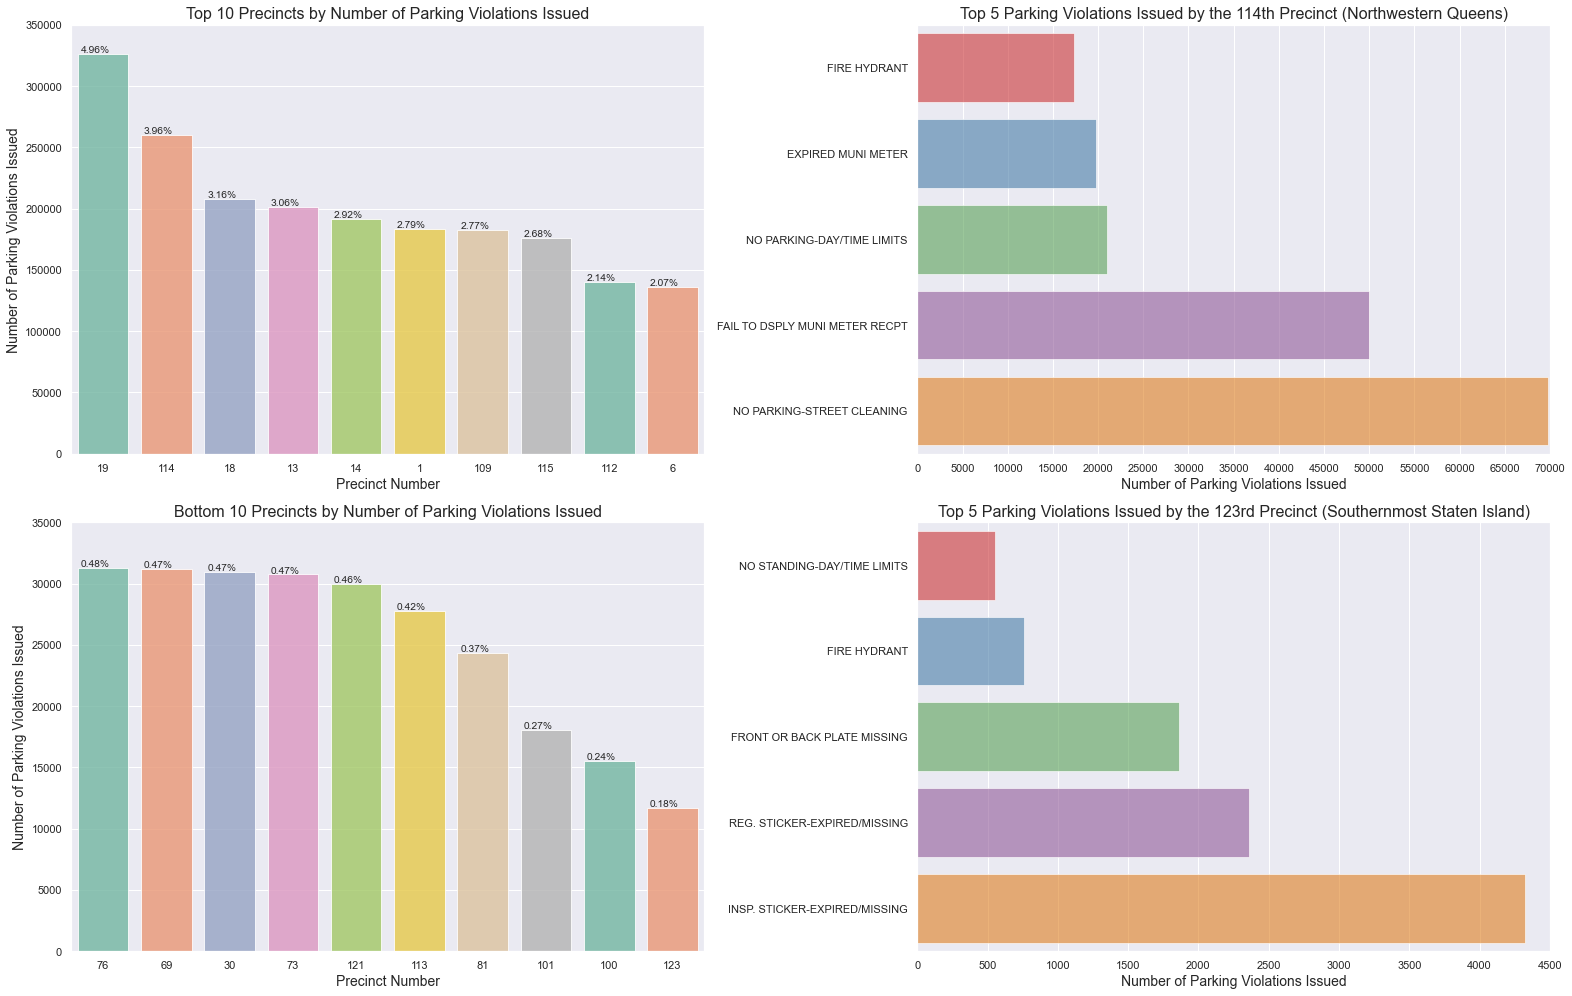

In [27]:
#precincts
allprecincts = pd.DataFrame(df.violation_precinct.value_counts()).sort_values('violation_precinct', ascending = False)
allprecincts['pct'] = (round((allprecincts['violation_precinct']/(allprecincts['violation_precinct'].sum()) * 100), 2))

sns.set(style='darkgrid')
plt.figure(figsize=(22, 14))

#highest ranking precincts
headprecincts = allprecincts.head(10)
xvalues = headprecincts.index.astype(str)
headprecinct_labels = (headprecincts.apply(lambda x: str(x[1]) + '%', axis=1)).tolist()

plt.subplot(2,2,1)

sns.barplot(y=headprecincts.violation_precinct, x=xvalues, palette='Set2', alpha = 0.8)
plt.title('Top 10 Precincts by Number of Parking Violations Issued', size = 16)
plt.xlabel('Precinct Number', size = 14)
plt.ylabel('Number of Parking Violations Issued', size = 14)
plt.ylim(0, 350000)
for i in range(len(xvalues)):
    plt.text(x = range(len(xvalues))[i] -.355, y = headprecincts.iloc[i][0]+1000, s = headprecinct_labels[i], size = 10.3)

#astoria (#2 and I lived there)
astoria = df[df['violation_precinct'] == 114]
astoria_types = pd.DataFrame(astoria.violation.value_counts().head()).sort_values('violation')
yvalues = astoria_types.index

plt.subplot(2,2,2)

sns.barplot(x=astoria_types.violation, y=yvalues, palette='Set1', alpha = 0.6)
plt.title('Top 5 Parking Violations Issued by the 114th Precinct (Northwestern Queens)', size = 16)
plt.xlabel('Number of Parking Violations Issued', size = 14)
plt.xlim(0,70001)
plt.xticks(np.arange(0,70001, 5000))

#lowest ranking precincts
tailprecincts = allprecincts[allprecincts['violation_precinct'] >= 11697].tail(10)
xvalues = tailprecincts.index.astype(str)
tailprecinct_labels = (tailprecincts.apply(lambda x: str(x[1]) + '%', axis=1)).tolist()

plt.subplot(2,2,3)

sns.barplot(y=tailprecincts.violation_precinct, x=xvalues, palette='Set2', alpha = 0.8)
plt.title('Bottom 10 Precincts by Number of Parking Violations Issued', size = 16)
plt.ylabel('Number of Parking Violations Issued', size = 14)
plt.xlabel('Precinct Number', size=14)
plt.ylim(0,35001)
for i in range(len(xvalues)):
    plt.text(x = range(len(xvalues))[i] -.355, y = tailprecincts.iloc[i][0]+100, s = tailprecinct_labels[i], size = 10.3)

#Lowest ranking precinct
tottenville = df[df['violation_precinct'] == 123]
tottenville_types = pd.DataFrame(tottenville.violation.value_counts().head()).sort_values('violation')
yvalues = tottenville_types.index

plt.subplot(2,2,4)

sns.barplot(x=tottenville_types.violation, y=yvalues, palette='Set1', alpha = 0.6)
plt.title('Top 5 Parking Violations Issued by the 123rd Precinct (Southernmost Staten Island)', size = 16)
plt.xlabel('Number of Parking Violations Issued', size = 14)
plt.xlim(0,4501)
plt.xticks(np.arange(0,4500.1, 500))

plt.tight_layout()
plt.show()

#### Locations of top 10 precincts, descriptions obtained from the <a href="https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page"> NYPD website</a>:
- <b>19th Precinct: Upper East Side Manhattan</b>
<br>"The precinct is one of the most densely populated residential areas in Manhattan. The southern part of the precinct has a large commercial area and features Madison, Lexington, and 3rd Avenues, which are well known for their shopping."

- <b>114th Precinct: Northwestern Queens</b>
<br>"Covers Astoria, Long Island City, Woodside, and Jackson Heights." I've lived by and learned to drive on Steinway Street. Double-parking galore!</br>
- <b>18th Precinct: Midtown North</b>
<br> "The precinct encompasses the Diamond District, St. Patrick's Cathedral, the Theatre District, Restaurant Row, Radio City Music Hall, and Rockefeller Plaza."
- <b>13th Precinct: Southeastern Midtown</b>
<br>"The precinct features the Peter Cooper Village/Stuyvesant Town residential complex, Gramercy Park, the lower portion of Rosehill, Madison Square Park, and Union Square Park."
- <b>14th Precinct: Midtown South</b>
<br>"The area contains commercial offices, hotels, Times Square, Grand Central Terminal, Penn Station, Madison Square Garden, Koreatown section, and the Manhattan Mall Plaza."</br>
- <b>1st Precinct: Southernmost square mile of Manhattan</b>
<br>"The precinct is home to the World Trade Center, SOHO, Tribeca, and Wall Street."</br>
- <b>109th Precinct: Northeastern Queens</b>
<br>"Including Downtown Flushing, East Flushing, Queensboro Hill, College Point, Malba, Whitestone, Beechhurst, and Bay Terrace."</br>
- <b>115th Precinct: Northern Queens</b>
<br>"Encompassing Jackson Heights, East Elmhurst, and North Corona. The precinct patrol responsibilities also include LaGuardia Airport."</br>
- <b>112th Precinct: Central Queens</b>
<br>"Housing Forest Hills and Rego Park."</br>
- <b>6th Precinct: Southwestern Manhattan</b>
<br>"Serves the southwestern Manhattan neighborhoods of Greenwich Village and the West Village."

#### Particularly interesting is the disproportionate representation by Queens precincts in the top 10 compared to its position in overall tickets issued (3rd), and the lack of representation by precincts in Brooklyn:
- 4 of the to 10 are in Queens, the rest Manhattan
<br>This could be a factor of population density within the boroughs. Perhaps the population of Queens is concentrated within only a few major zones whereas Brooklyn's population is more dispersed.</br>
The most frequent violation types issused by the Northwestern Queens Precinct are more or less ordered the same as the overall observations.

#### Locations of bottom 10 precincts:
- <b>123rd Precinct: Southernmost Staten Island</b>
<br>"Includes Tottenville, Huguenot, Rossville, Annadale, and Eltingville."
<br> The Precinct follows overall Staten Island violation type pattern: Missing/expired registration or inspection stickers in the top 2.

- <b>76th Precinct: Southern Brooklyn</b>
<br>"Includes the neighborhoods of Carroll Gardens, Red Hook, Cobble Hill, parts of Gowanus, and the Columbia Street Waterfront District."
- <b>69th Precinct: Eastern Brooklyn</b>
<br>"Serves the Canarsie section of Brooklyn. The precinct is mostly residential with commercial strips along Avenue L, Rockaway Parkway, and Remsen Avenue.</br>
- <b>30th Precinct: Western Harlem</b>
<br> "The neighborhoods covered by the precinct are Hamilton Heights, Sugar Hill, and West Harlem. The precinct contains Riverside Park and Jackie Robinson Park."
- <b>73rd Precinct: Northeastern Brooklyn</b>
<br>"Brownsville and Ocean Hill"
- <b>121st Precinct: Northwestern Staten Island</b>
<br>"Containing Willowbrook, Westerleigh, Port Richmond, Mariner's Harbor, Elm Park, Port Ivory, Chelsea, and Bloomfield."</br>
- <b>113th Precinct: Eastern Queens</b>
<br>"Serves the southeastern area of Jamaica, Queens, along with St. Albans, Hollis, Springfield Gardens, South Ozone Park, South Jamaica, Addisleigh Park, and Locust Manor."</br>
- <b>81st Precinct: Northern Brooklyn</b>
<br>"Containing Bedford Stuyvesent and Stuyvesant Heights"</br>
- <b>101st Precinct: Eastern Rockaways, Queens</b>
<br>"Houses Far Rockaway and Bayswater."</br>
- <b>100th Precinct: Western Rockaways, Queens</b>
<br>"Contains Arverne, Belle Harbor, Breezy Point, Broad Channel, Neponsit, Rockaway Park, Rockaway Beach, and Roxbury.."</br>

### Top 10 Streets:

In [28]:
addresses = df[['address','violation']]
address_pivot = addresses.pivot_table(index='address', columns='violation', aggfunc=len, margins=True, margins_name='Total', fill_value = 0)

topstreets = address_pivot.sort_values('Total', ascending=False).sort_values('Total',axis=1,ascending=False).iloc[:11,:20].sort_values('W BROADWAY MANHATTAN',axis=1,ascending=False).iloc[:,:18]

topstreets

violation,Total,FAIL TO DSPLY MUNI METER RECPT,DOUBLE PARKING,FAIL TO DISP. MUNI METER RECPT,NO STANDING-EXC. TRUCK LOADING,NO STANDING-DAY/TIME LIMITS,NO STANDING-BUS STOP,EXPIRED MUNI METER,NO PARKING-STREET CLEANING,CROSSWALK,NO PARKING-DAY/TIME LIMITS,NO STANDING-COMM METER ZONE,FIRE HYDRANT,INSP. STICKER-EXPIRED/MISSING,FRONT OR BACK PLATE MISSING,REG. STICKER-EXPIRED/MISSING,DOUBLE PARKING-MIDTOWN COMML,NO STOPPING-DAY/TIME LIMITS
address,,,,,,,,,,,,,,,,,,
Total,6578587,793989,335180,168938,204080,613634,182647,236501,1163700,73262,561928,160256,475264,470738,210762,278324,73791,47045
W BROADWAY MANHATTAN,5972,964,599,576,477,471,373,370,332,302,298,242,191,147,119,107,67,37
W MADISON AVE MANHATTAN,5598,855,763,607,2,690,11,544,381,298,33,220,184,202,136,137,247,2
E BROADWAY MANHATTAN,5396,1011,663,303,163,315,400,409,253,419,144,168,190,180,143,108,90,121
W 3RD AVE MANHATTAN,4572,625,1004,374,153,147,24,243,164,295,53,102,193,119,89,72,350,4
N QUEENS BLVD QUEENS,4342,1402,32,0,258,641,104,601,553,119,28,0,108,177,106,146,0,0
2655 RICHMOND AVE STATEN ISLAND,4323,0,1,0,0,2,0,0,1,1,4,0,0,1968,691,1154,0,0
S QUEENS BLVD QUEENS,3933,1206,37,0,116,522,375,515,498,68,178,0,56,132,75,97,0,0
E 2ND AVE MANHATTAN,3722,273,489,161,3,401,9,68,101,194,72,100,94,63,87,34,249,1011


#### It is suprising to see a Staten Island address on the list:
- The only address in the top 10 to have a specific 'house number' as opposed to a cardinal direction, 2655 RICHMOND AVE is home to the <a href='https://www.statenislandmall.com/en.html'> Staten Island Mall</a> which is the largest shopping center in the borough, hosting 211 stores.
- Unique to Richmond Ave is the large majority of tickets being issued for plate or sticker violations.


### Vehicle Color Representation in Parking Violations

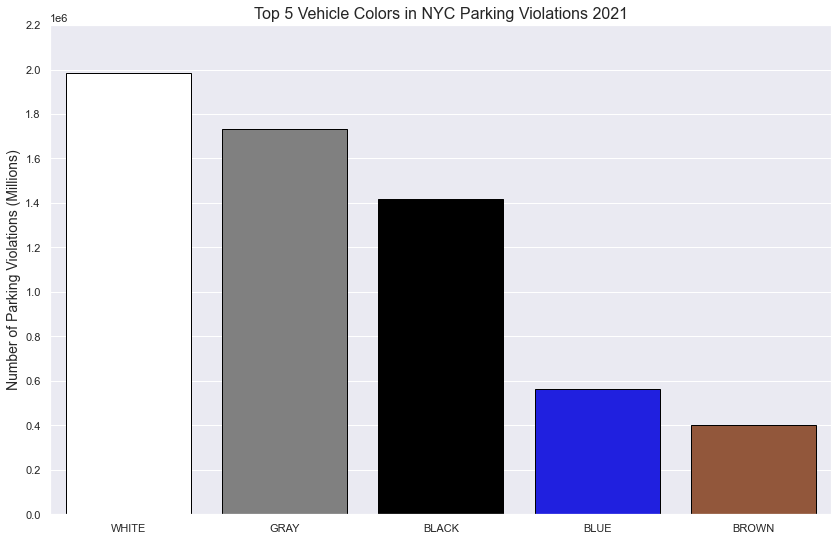

In [50]:
#change plot type
colors = pd.DataFrame(df.vehicle_color.value_counts().head(5)).sort_values('vehicle_color', ascending = False)
yvalues = colors.index

sns.set(style="darkgrid")
plt.figure(figsize=(14, 9))

sns.barplot(y=colors.vehicle_color, x=yvalues, palette=['white','gray','black','blue','sienna'], edgecolor='black')
plt.title('Top 5 Vehicle Colors in NYC Parking Violations 2021', size = 16)
plt.ylabel('Number of Parking Violations (Millions)', size = 14)
plt.ylim(0,2200001)
plt.yticks(np.arange(0,2200001, 200000))
plt.show()

But how different is this representation compared to frequency of vehicle colors in the US?
<br>US car color proportions derived from <a href= 'https://www.iseecars.com/most-popular-car-colors-study'> ISeeCars analysis</a> of over 9.4 million used cars sold in 2019.
<br>We are assuming color trends of NYC/NYS/Other represented vehicles are equivalent to the US as a whole.

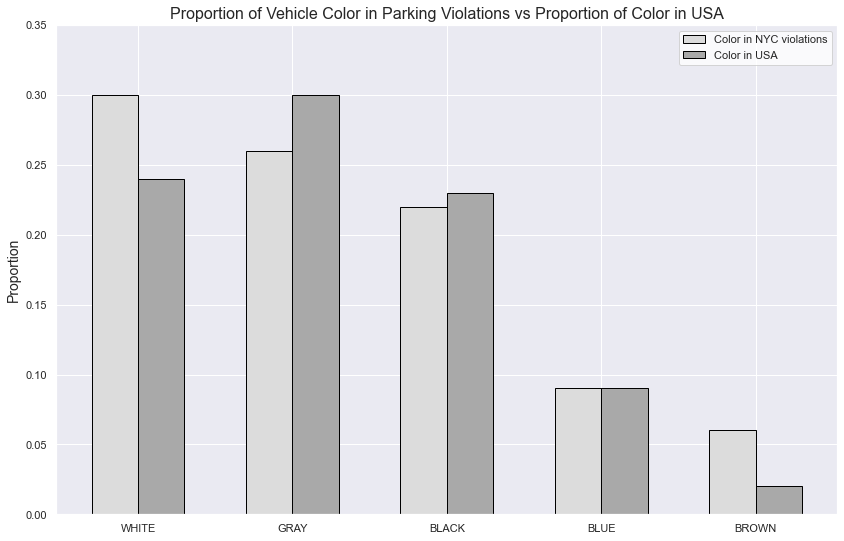

In [30]:
plt.figure(figsize=(14, 9))
barWidth = 0.3
bar1h = [0.30, 0.26, 0.22, 0.09, 0.06]
bar2h = [0.24, 0.30, 0.23, 0.09, 0.02]
x1coords = np.arange(len(yvalues))
x2coords = [x + barWidth for x in x1coords]
plt.bar(x = x1coords, height = bar1h, width = barWidth, edgecolor = 'black', color = 'gainsboro', label = 'Color in NYC violations')
plt.bar(x = x2coords, height = bar2h, width = barWidth, edgecolor = 'black', color = 'darkgray', label = 'Color in USA')
plt.title('Proportion of Vehicle Color in Parking Violations vs Proportion of Color in USA', size = 16)
plt.ylabel('Proportion', size = 14)
plt.legend(facecolor = 'white')
plt.xticks([r + 0.5 * barWidth for r in range(len(bar1h))], ['WHITE', 'GRAY', 'BLACK', 'BLUE', 'BROWN'])
plt.yticks(np.arange(0,0.355, 0.05))
plt.show()

The trends in NYC are more or less aligned with population of these car colors in the US, so no, you are not more likely to get a parking ticket just because your car is in a grayscale color!
<br> White and Brown are exceptions. Perhaps the colors are more popular in NYC than the US.

In [31]:
colors['Proportion'] = (colors['vehicle_color'] / len(df)).round(decimals = 2)
colors['proportion_usa'] = ['0.24','0.30', '0.23', '0.09','0.02']
colors

,vehicle_color,Proportion,proportion_usa
WHITE,1985130,0.30,0.24
GRAY,1730513,0.26,0.30
BLACK,1416740,0.22,0.23
BLUE,562522,0.09,0.09
BROWN,402286,0.06,0.02


### Car Type:

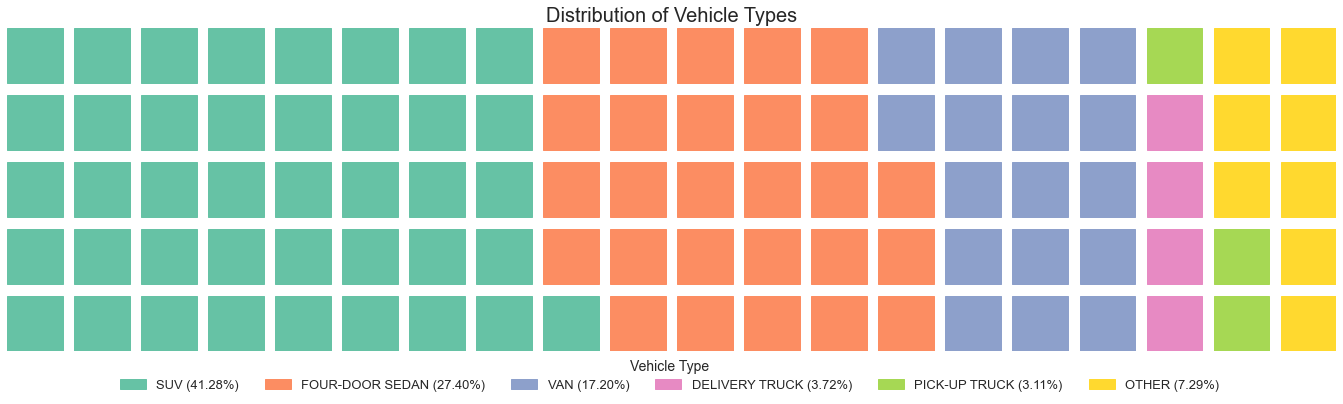

In [32]:
make_body_df = df[['vehicle_body_type', 'vehicle_make', 'violation', 'violation_county']]
body_grpdf = pd.DataFrame(make_body_df.vehicle_body_type.value_counts())
body_grpdf = body_grpdf.sort_values('vehicle_body_type')
body_grpdf['pct'] = (round((body_grpdf.vehicle_body_type/body_grpdf.vehicle_body_type.sum())*100,0))
body_grpdf_top = body_grpdf[body_grpdf['pct']>=2.9].sort_values('pct', ascending = False)
body_grpdf_top = pd.concat([body_grpdf_top, (pd.DataFrame(data= {'vehicle_body_type':((len(df)-body_grpdf_top.vehicle_body_type.sum())) ,'pct':(100 - body_grpdf_top.pct.sum())}, index=['OTHER']))])
body_grpdf_top

from pywaffle import Waffle

fig = plt.figure(FigureClass=Waffle,
                 rows=5,
                 columns=20,
                 values=body_grpdf_top.pct,
                 title={'label':'Distribution of Vehicle Types', 'loc':'center', 'fontdict':{'fontsize':20}},
                 labels=['SUV (41.28%)','FOUR-DOOR SEDAN (27.40%)','VAN (17.20%)','DELIVERY TRUCK (3.72%)','PICK-UP TRUCK (3.11%)','OTHER (7.29%)'],
                 legend={'loc': 'lower left','bbox_to_anchor': (0.076, -0.16),'fontsize':13, 'ncol':6, 'framealpha':0, 'title':'Vehicle Type', 'title_fontsize':14, 'frameon':False},
                 figsize=(20,20))
plt.show()

It would be interesting to compare these results with <a href="https://data.ny.gov/Transportation/Vehicle-Makes-and-Body-Types-Most-Popular-in-New-Y/3pxy-wy2i"> NYS's Vechicle Makes and Body Types dataset</a>.
<br> I think our observations are very much in line with the prevalence of these vehicles in NYC as a whole, much like color. 
<br> In our dataset, SUV's are the most represented body type in each borough with the exception of Manhattan.

In [33]:
#Creating Dataframes of our top 10 vehicle body types in each borough

top_ten_body = body_grpdf.index

nyc_bodydf = pd.DataFrame(nyc.vehicle_body_type[nyc.vehicle_body_type.isin(top_ten_body)].value_counts())
nyc_bodydf['Percent'] = (round((nyc_bodydf.vehicle_body_type / len(nyc)),4) * 100)
othernyccount = len(nyc) - nyc_bodydf.vehicle_body_type.sum()
othernycpercent = 100 - nyc_bodydf.Percent.sum()
othernyc = pd.DataFrame({'vehicle_body_type':[othernyccount],'Percent':[othernycpercent]})
othernyc.index = ['OTHER']
nyc_bodydf = pd.concat([nyc_bodydf, othernyc])
nyc_bodydf['borough'] = 'MANHATTAN'

bklyn_bodydf = pd.DataFrame(bklyn.vehicle_body_type[bklyn.vehicle_body_type.isin(top_ten_body)].value_counts())
bklyn_bodydf['Percent'] = (round((bklyn_bodydf.vehicle_body_type / len(bklyn)),4) * 100)
otherbklyncount = len(bklyn) - bklyn_bodydf.vehicle_body_type.sum()
otherbklynpercent = 100 - bklyn_bodydf.Percent.sum()
otherbklyn = pd.DataFrame({'vehicle_body_type':[otherbklyncount],'Percent':[otherbklynpercent]})
otherbklyn.index = ['OTHER']
bklyn_bodydf = pd.concat([bklyn_bodydf, otherbklyn])
bklyn_bodydf['borough'] = 'BROOKLYN'

queens_bodydf = pd.DataFrame(queens.vehicle_body_type[queens.vehicle_body_type.isin(top_ten_body)].value_counts())
queens_bodydf['Percent'] = (round((queens_bodydf.vehicle_body_type / len(queens)),4) * 100)
otherqueenscount = len(queens) - queens_bodydf.vehicle_body_type.sum()
otherqueenspercent = 100 - queens_bodydf.Percent.sum()
otherqueens = pd.DataFrame({'vehicle_body_type':[otherqueenscount],'Percent':[otherqueenspercent]})
otherqueens.index = ['OTHER']
queens_bodydf = pd.concat([queens_bodydf, otherqueens])
queens_bodydf['borough'] = 'QUEENS'

bronx_bodydf = pd.DataFrame(bronx.vehicle_body_type[bronx.vehicle_body_type.isin(top_ten_body)].value_counts())
bronx_bodydf['Percent'] = (round((bronx_bodydf.vehicle_body_type / len(bronx)),4) * 100)
otherbronxcount = len(bronx) - bronx_bodydf.vehicle_body_type.sum()
otherbronxpercent = 100 - bronx_bodydf.Percent.sum()
otherbronx = pd.DataFrame({'vehicle_body_type':[otherbronxcount],'Percent':[otherbronxpercent]})
otherbronx.index = ['OTHER']
bronx_bodydf = pd.concat([bronx_bodydf, otherbronx])
bronx_bodydf['borough'] = 'BRONX'

staten_bodydf = pd.DataFrame(staten.vehicle_body_type[staten.vehicle_body_type.isin(top_ten_body)].value_counts())
staten_bodydf['Percent'] = (round((staten_bodydf.vehicle_body_type / len(staten)),4) * 100)
otherstatencount = len(staten) - staten_bodydf.vehicle_body_type.sum()
otherstatenpercent = 100 - staten_bodydf.Percent.sum()
otherstaten = pd.DataFrame({'vehicle_body_type':[otherstatencount],'Percent':[otherstatenpercent]})
otherstaten.index = ['OTHER']
staten_bodydf = pd.concat([staten_bodydf, otherstaten])
staten_bodydf['borough'] = 'STATEN ISLAND'

#putting them all together...
frames = [nyc_bodydf, bklyn_bodydf, queens_bodydf, bronx_bodydf, staten_bodydf]
top_body = pd.concat(frames)

#and separating again by body type
suv = top_body.loc[(top_body.index=='SUV')]
fdoor = top_body.loc[(top_body.index=='FOUR-DOOR SEDAN')]
van = top_body.loc[(top_body.index=='VAN')]
delivery = top_body.loc[(top_body.index=='DELIVERY TRUCK')]
pu = top_body.loc[(top_body.index=='PICK-UP TRUCK')]
tdoor = top_body.loc[(top_body.index=='TWO-DOOR SEDAN')]
sedan = top_body.loc[(top_body.index=='SEDAN')]
semi = top_body.loc[(top_body.index=='SEMI-TRAILER')]
conv = top_body.loc[(top_body.index=='CONVERTIBLE')]
util = top_body.loc[(top_body.index=='UTILITY')]
other = top_body.loc[(top_body.index=='OTHER')]

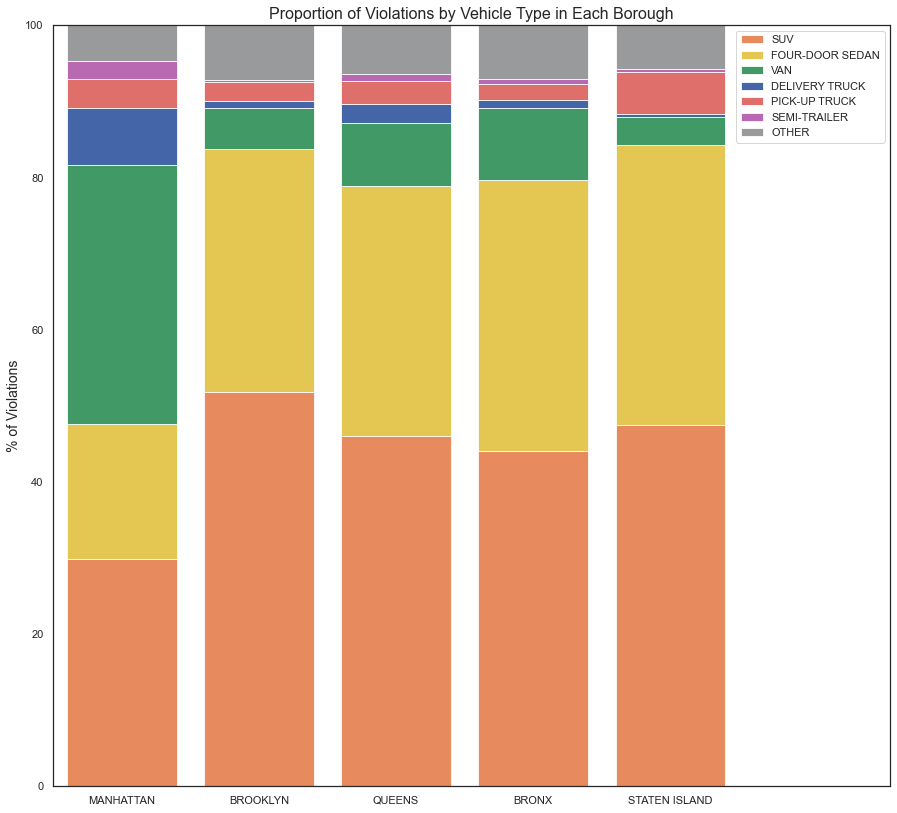

In [34]:
# Bar stack y values

bar3h = np.add(fdoor.Percent.tolist(),suv.Percent.tolist()).tolist()
bar4h = np.add(bar3h, van.Percent.tolist()).tolist()
bar5h = np.add(bar4h, delivery.Percent.tolist()).tolist()
bar6h = np.add(bar5h, pu.Percent.tolist()).tolist()
bar7h = np.add(bar6h, semi.Percent.tolist()).tolist()
othery = np.subtract(100, bar7h)

sns.set(style='white')

# Each bar corresponds to a body type

body_borough = pd.DataFrame(top_body.groupby('borough')['vehicle_body_type'].sum().sort_values(ascending = False))
plt.figure(figsize=(15, 14))
bar1 = sns.barplot(x=suv.borough, y=suv.Percent, color='#FF6319', label='SUV', alpha=0.8)
bar2 = sns.barplot(x=fdoor.borough, y=fdoor.Percent, bottom=suv.Percent, color='#FCCC0A', label='FOUR-DOOR SEDAN', alpha=0.8)
bar3 = sns.barplot(x=van.borough, y=van.Percent, bottom=bar3h, color='#00933C', label='VAN', alpha=0.8)
bar4 = sns.barplot(x=delivery.borough, y=delivery.Percent, bottom=bar4h, color='#0039A6', label='DELIVERY TRUCK', alpha=0.8)
bar5 = sns.barplot(x=pu.borough, y=pu.Percent,bottom=bar5h, color='#EE352E', label='PICK-UP TRUCK', alpha=0.8)
bar6 = sns.barplot(x=semi.borough, y=semi.Percent, bottom=bar6h, color='#B933AD', label='SEMI-TRAILER', alpha=0.8)
bar7 = sns.barplot(x=other.borough, y=othery, bottom=bar7h, color='#808183', label='OTHER', alpha=0.8)
plt.legend(facecolor = 'white')
plt.title('Proportion of Violations by Vehicle Type in Each Borough', size=16)
plt.ylabel('% of Violations', size=14)
plt.xlabel('')
plt.ylim(0,100.01)
plt.xlim(-0.5,5.6)

plt.show()

Vans and delivery trucks receive proportionately far more tickets in Manhattan than anywhere else, ranking 1st and 4th overall with 34.0% and 7.4% of tickets in the borough respectively.

SUVs in Manhattan make up 29.9% of tickets, ranking second overall.
<br> In comparison, SUVs make up 51.8% of tickets in Brooklyn. Vans and delivery trucks account for 5.4% and 0.86% respectively. The trends are similar in the remaining 3 boroughs.

In [69]:
# compare delivery truck violations to suv violations
delivery_trucks = df[['vehicle_body_type','violation']][df['vehicle_body_type'] == 'DELIVERY TRUCK']
print('Top 5 Delivery Truck Violations:')
print(delivery_trucks.violation.value_counts().head())

Top 5 Delivery Truck Violations:
NO STANDING-DAY/TIME LIMITS     48174
DOUBLE PARKING                  33891
DOUBLE PARKING-MIDTOWN COMML    24646
NO PARKING-DAY/TIME LIMITS      19691
NO STANDING-BUS STOP            19141
Name: violation, dtype: int64


In [36]:
suvs = df[['vehicle_body_type','violation']][df['vehicle_body_type'] == 'SUV']
print('Top 5 SUV violations:')
print(suvs.violation.value_counts().head())

Top 5 SUV violations:
NO PARKING-STREET CLEANING        602888
FAIL TO DSPLY MUNI METER RECPT    387504
NO PARKING-DAY/TIME LIMITS        219841
INSP. STICKER-EXPIRED/MISSING     219705
FIRE HYDRANT                      209811
Name: violation, dtype: int64


In [70]:
suvs = df[df['vehicle_body_type'] == 'SUV']
print("Average violation fine for SUVs:", suvs.violation_fine.mean())

vans = df[df['vehicle_body_type'] == 'VAN']
print("Average violation fine for Vans:", vans.violation_fine.mean())

fourdoor = df[df['vehicle_body_type'] == 'DELIVERY TRUCK']
print("Average violation fine for Four-door sedans:", fourdoor.violation_fine.mean())

semi = df[df['vehicle_body_type'] == 'SEMI-TRAILER']
print("Average violation fine for Semi-Trucks:", semi.violation_fine.mean())

Average violation fine for SUVs: 69.72423510452163
Average violation fine for Vans: 80.29913278064416
Average violation fine for Four-door sedans: 94.67002193726026
Average violation fine for Semi-Trucks: 90.80270531173478


### Meter Violations:

In [38]:
#violation time for meters: "when are most drivers getting caught?"
timesdf = df[['violation_time','violation','violation_county']]
timesdf = timesdf.loc[(timesdf['violation'] == 'EXPIRED MUNI METER') | (timesdf['violation'] == 'FAIL TO DSPLY MUNI METER RECPT') | (timesdf['violation'] == 'EXPIRED MUNI MTR-COMM MTR ZN')]
meter_times = pd.DataFrame(timesdf.violation_time.value_counts())
meter_times_top = meter_times.head(5)
labels = ['n = 181,085', 'n = 143,580', 'n = 135,342', 'n = 107,642', 'n = 107,527']

print('Total number of meter violations in 2021:', '{:,}'.format(len(timesdf)), '- making up', (round(((len(timesdf)/len(df)) * 100),2)), '% of violations.')

Total number of meter violations in 2021: 1,066,333 - making up 16.21 % of violations.


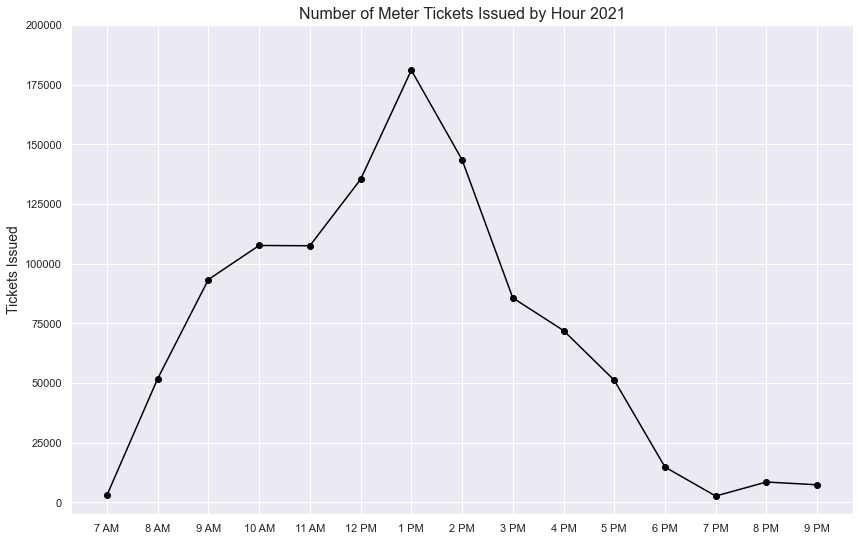

In [39]:
meterdict_sort = {'violation_time': ['7 AM', '8 AM', '9 AM', '10 AM', '11 AM', '12 PM',
       '1 PM', '2 PM', '3 PM', '4 PM', '5 PM', '6 PM',
       '7 PM', '8 PM', '9 PM'], 'tickets_issued': [3022,51858,93384,107642,107527,135342,181085,143580,85676,72013,51205,14802,2653,8524,7367]}
meters_sorted = pd.DataFrame(meterdict_sort, index=np.arange(0,15,1))

sns.set(style='darkgrid')

xvalues = meters_sorted.violation_time
yvalues = meters_sorted.tickets_issued
plt.figure(figsize=(14, 9))
plt.plot(xvalues,yvalues, color='black', marker='o')
plt.ylim(-5000,200001)
plt.title('Number of Meter Tickets Issued by Hour 2021', size = 16)
plt.ylabel('Tickets Issued', size = 14)
plt.ticklabel_format(axis = 'y', style = 'plain')

plt.show()

Tickets peak at lunch hours! Take extra care when leaving your car to grab a quick bite!

There could be less patrols during 7 AM and 7 PM as these are typically the hours between which meters are active.
<br> There are probably more cars on the road during these hours as drivers make their way to and from work.

### Vehicle Age:

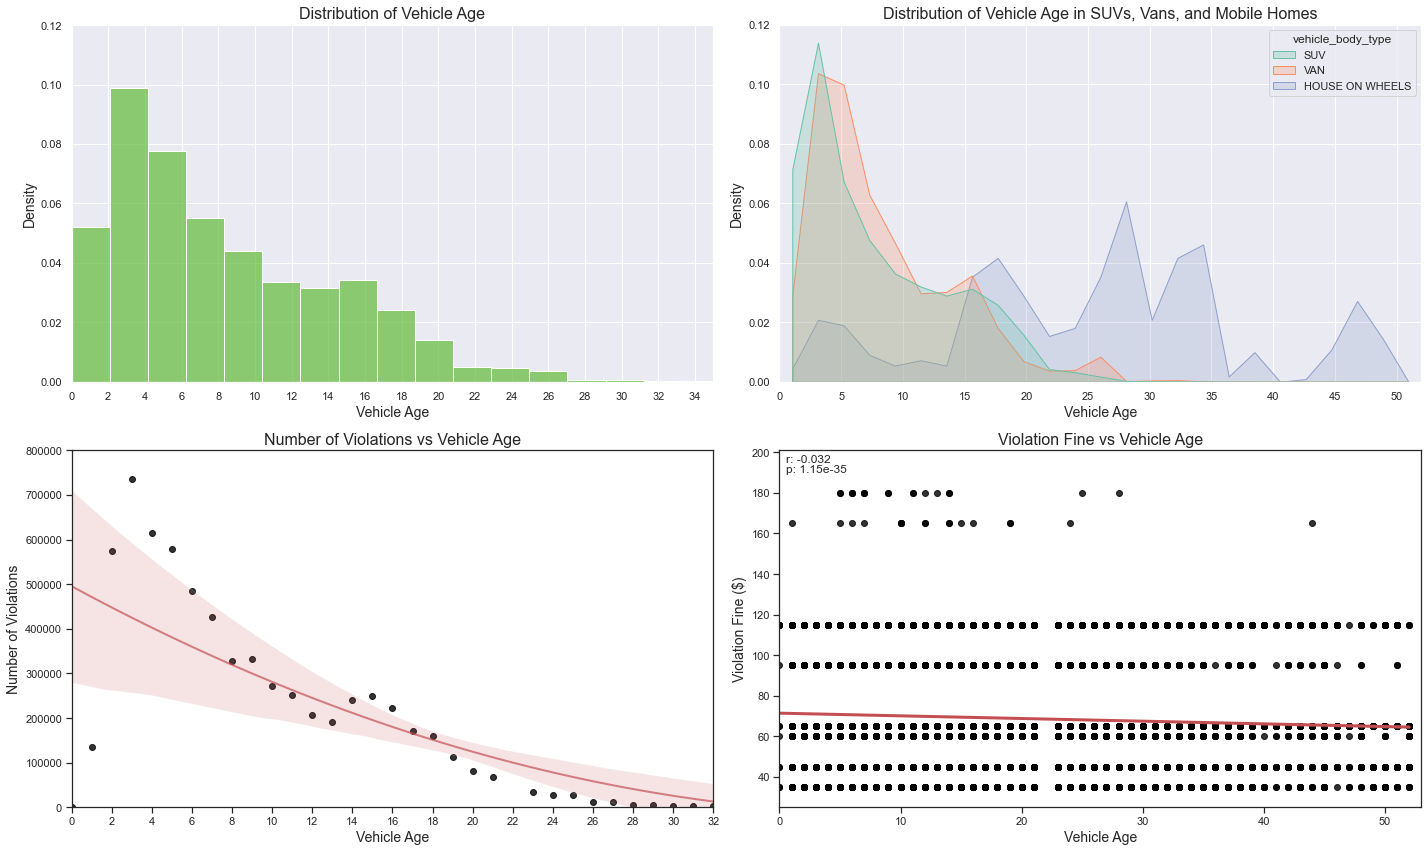

In [40]:
#vehicle age vs number of tickets
df['age'] = 2022 - df['vehicle_year']
age_counts = pd.DataFrame(df.age.value_counts().head(50))

sns.set(style='darkgrid')
plt.figure(figsize=(20, 12))

#
plt.subplot(2,2,1)

sns.histplot(data=df, x='age',bins=25, stat='density',color='#6CBE45')
plt.title('Distribution of Vehicle Age',size=16)
plt.xlabel('Vehicle Age',size=14)
plt.ylabel('Density',size=14)
plt.xlim(0,35)
plt.xticks(np.arange(0,35,2))
plt.ylim(0,0.1201)

#
bodytypes = df[df['vehicle_body_type'].isin(['SUV','HOUSE ON WHEELS','VAN'])]

plt.subplot(2,2,2)

sns.histplot(bodytypes,x=bodytypes.age,hue=bodytypes.vehicle_body_type,element='poly',stat='density',common_norm=False,bins=25,palette='Set2')
plt.title('Distribution of Vehicle Age in SUVs, Vans, and Mobile Homes',size=16)
plt.xlim(0,52)
plt.xticks(np.arange(0,51,5))
plt.xlabel('Vehicle Age',size=14)
plt.ylim(0,0.12001)
plt.ylabel('Density',size=14)

#violations vs vehicle age
sns.set(style='ticks')

plt.subplot(2,2,3)

sns.regplot(x=age_counts.index,y=age_counts.age, color='black', line_kws={'color':'r','alpha':0.7,'lw':2}, ci=95, order = 2)
plt.title('Number of Violations vs Vehicle Age', size = 16)
plt.xlim(1,32)
plt.xticks(np.arange(0, 33,2))
plt.xlabel('Vehicle Age', size = 14)
plt.ylabel('Number of Violations', size = 14)
plt.ylim(0,800001)

plt.subplot(2,2,4)

#Subset of 2door sedans for ease of processing 
twodoor = df[df['vehicle_body_type'] == 'TWO-DOOR SEDAN']

sns.regplot(x=twodoor.age,y=twodoor.violation_fine, color='black', line_kws={'color':'r','lw':3}, ci=95)
plt.title('Violation Fine vs Vehicle Age', size = 16)
plt.xlabel('Vehicle Age', size = 14)
plt.xlim(0,53)
plt.ylabel('Violation Fine ($)', size = 14)
plt.ylim(25,201)

slope, intercept, pearson_coeff, p_value, std_err = stats.linregress(x=twodoor.age,y=twodoor.violation_fine)
plt.text(0.5,195,'r: -0.032')
plt.text(0.5,190,'p: 1.15e-35')

plt.tight_layout()
plt.show()

The older the car, the more likely it is to be parked at the scrapyard, not the streets of NYC.
<br>0 correlation between violation fine and vehicle age.

### What about Motorcycles?

They're small enough to park between cars and are easy to store, so it's no suprise that they are among the vehicle types with the least amount of tickets received (11th).

C:\Users\sarzy\AppData\Local\Temp\ipykernel_3324\1634852860.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


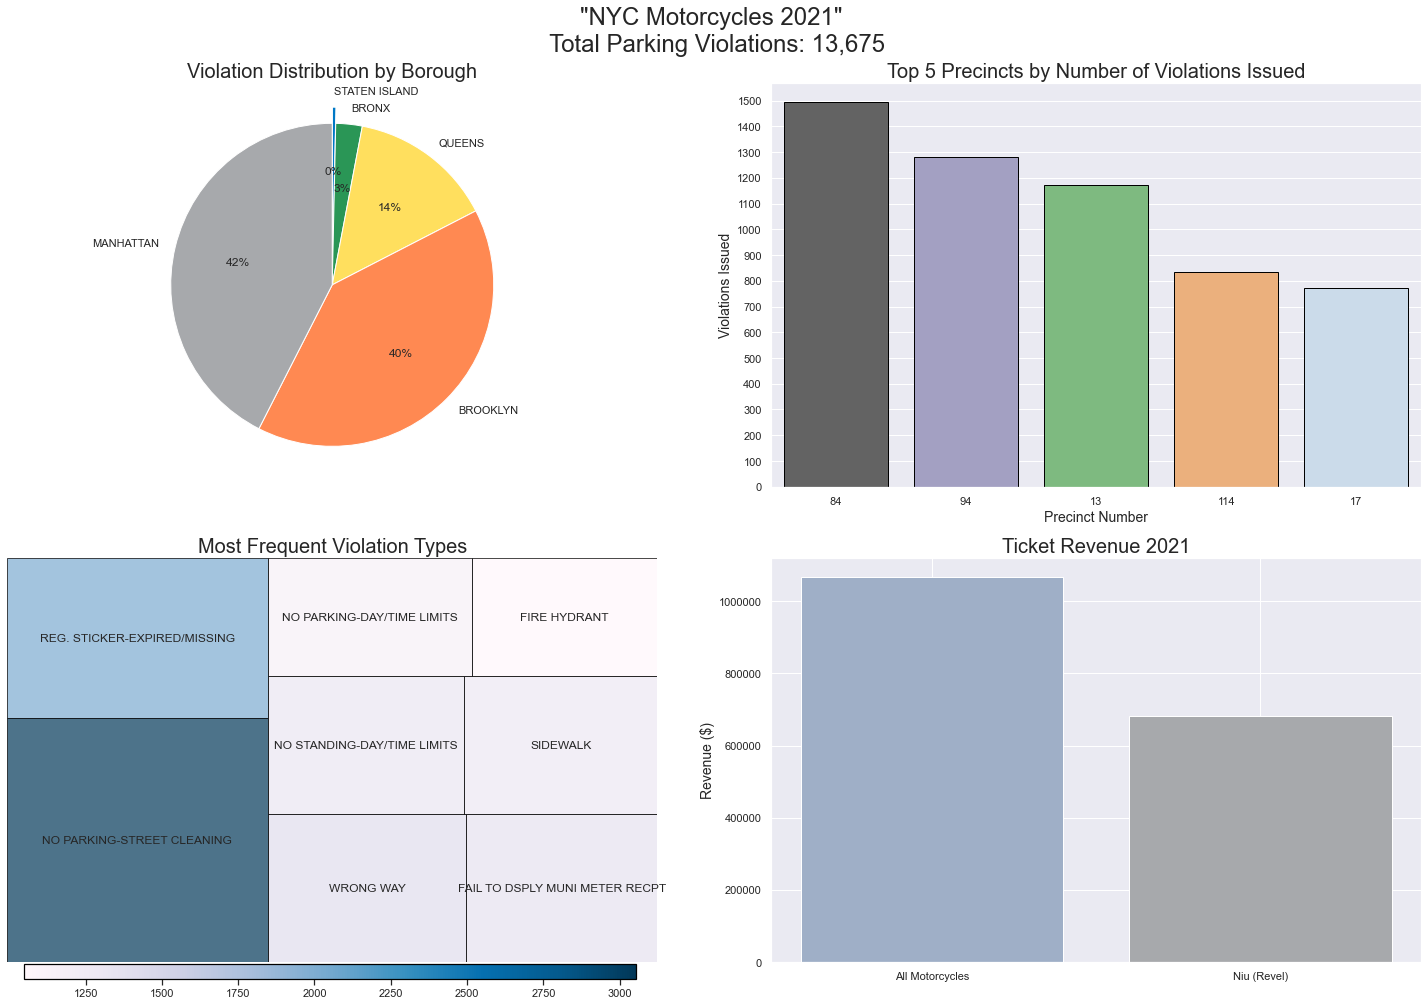

In [66]:
bikes = df[(df['vehicle_body_type'] == 'MOTORCYCLE') | (df['vehicle_body_type'] == 'MOPED')]
plt.figure(figsize=(20,14))

bike_boroughs = bikes['violation_county'].value_counts(ascending=True)

plt.subplot(2,2,1)

plt.pie(bike_boroughs, labels=bike_boroughs.index, colors=['#0078C6', '#2a9656', '#ffdf5e', '#ff8952', '#A7A9AC'], 
       wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, autopct='%.0f%%', shadow=False, startangle=90,
       explode=(0.1,0.0,0.0,0.0,0.0), counterclock=False, )
plt.title('Violation Distribution by Borough', size=20)

bike_precincts = pd.DataFrame(bikes['violation_precinct'].value_counts().head())

sns.set(style='darkgrid')

plt.subplot(2,2,2)

sns.barplot(x=bike_precincts.index.astype(str),y=bike_precincts.violation_precinct,palette='tab20c_r', edgecolor='black')
plt.title('Top 5 Precincts by Number of Violations Issued', size=20)
plt.ylabel('Violations Issued', size=14)
plt.xlabel('Precinct Number', size=14)
plt.yticks(np.arange(0, 1501, 100))

plt.subplot(2,2,3)

bike_violations = bikes['violation'].value_counts(ascending=False).head(8)

cmap = matplotlib.cm.PuBu
mini=min(bike_violations)
maxi=max(bike_violations)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in bike_violations]

squarify.plot(sizes=bike_violations, label=bike_violations.index, alpha=.7, color = colors, edgecolor='black')
plt.axis('off')
plt.title('Most Frequent Violation Types', size=20)

plt.rcParams['axes.grid'] = False
cax = plt.axes([0.021, 0.015, 0.425, 0.015])
plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal').outline.set_edgecolor('black')

sns.set(style='darkgrid')

plt.subplot(2,2,4)

#These are Revel scooters 
revel = bikes[bikes['vehicle_make'] == 'NIU']

plt.bar(x='All Motorcycles', height=bikes.violation_fine.sum(), color='#9fafc7')
plt.bar(x='Niu (Revel)', height=revel.violation_fine.sum(), color='#A7A9AC')
plt.title('Ticket Revenue 2021', size=20)
plt.ylabel('Revenue ($)', size=14)

plt.suptitle('"NYC Motorcycles 2021" \n Total Parking Violations: 13,675',size=24)
plt.ticklabel_format(style='plain',axis='y')
plt.tight_layout()

plt.show()

A large majority of motorcycles with make 'Niu' are likely <a href='https://gorevel.com'> Revel</a> mopeds. The top 5 Precincts' zones are Revel hotspots. 
<br>Inexperienced or carefree moped renters may account for the majority of odd violation types seen amongst motorcycles including 'Wrong Way' and 'Sidewalk.'

### Doctors?

C:\Users\sarzy\AppData\Local\Temp\ipykernel_3324\2151248005.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


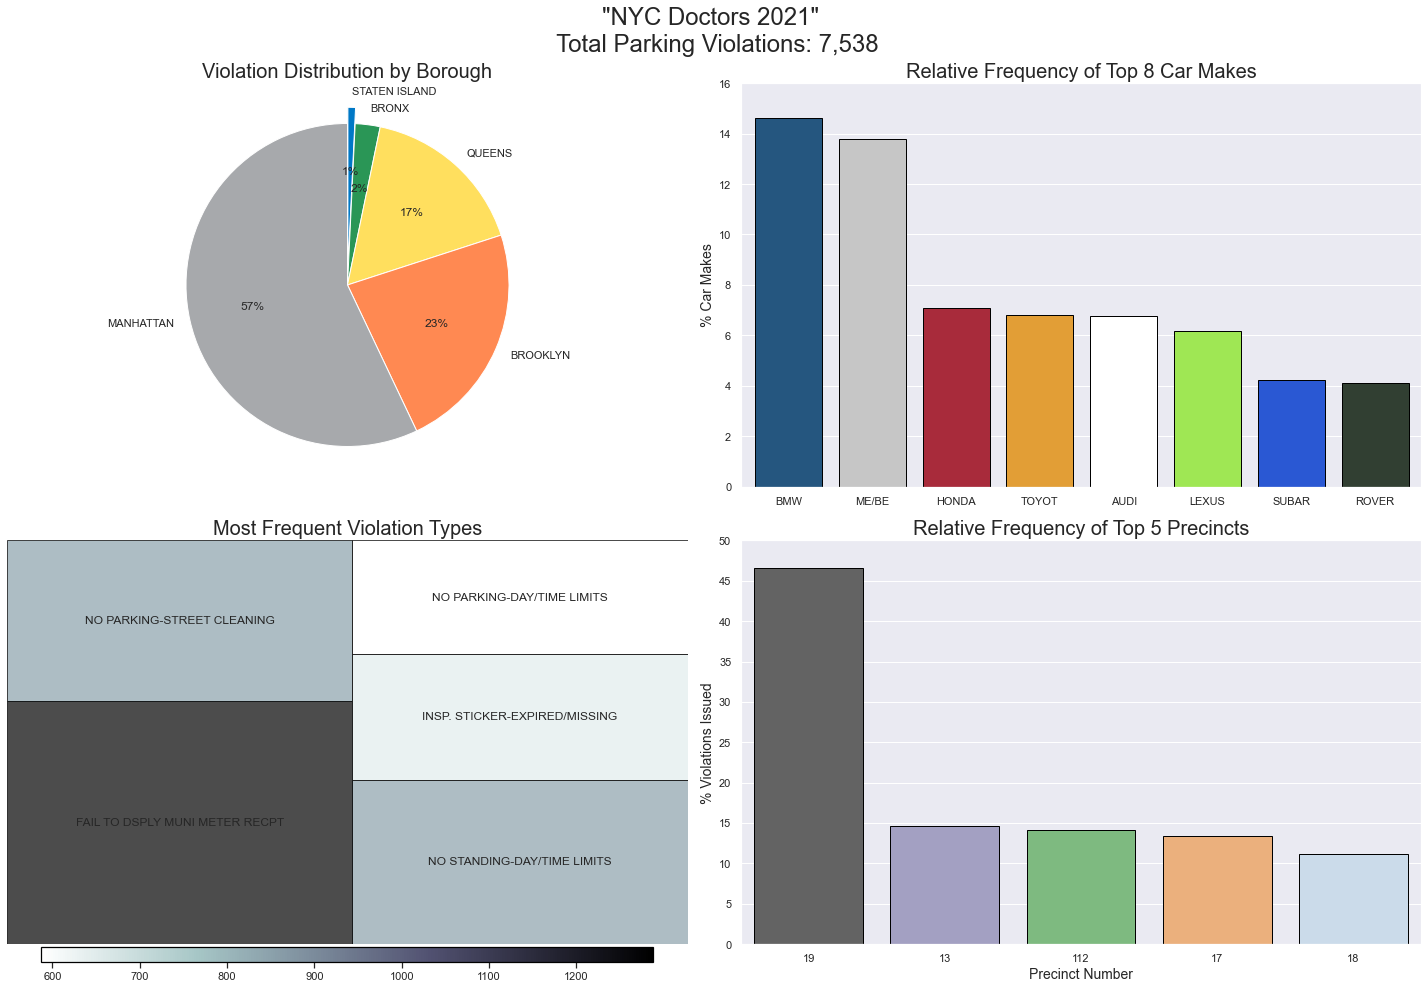

In [67]:
plt.figure(figsize=(20,14))
sns.set(style='darkgrid')

doctors = df[df['plate_type'] == 'MEDICAL DOCTOR']

# Borough counts
doc_boroughs = doctors['violation_county'].value_counts(ascending=True)

plt.subplot(2,2,1)

plt.pie(doc_boroughs, labels=doc_boroughs.index, colors=['#0078C6', '#2a9656', '#ffdf5e', '#ff8952', '#A7A9AC'], 
       wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, autopct='%.0f%%', shadow=False, startangle=90,
       explode=(0.1,0.0,0.0,0.0,0.0), counterclock=False, )
plt.title('Violation Distribution by Borough', size=20)

# Vehicle make
doc_carmodel = pd.DataFrame(doctors['vehicle_make'].value_counts(ascending=False))
doc_carmodel['freq'] = round((doc_carmodel['vehicle_make']/sum(doc_carmodel.vehicle_make)) * 100,2)

plt.subplot(2,2,2)

sns.barplot(x=doc_carmodel.head(8).index,y=doc_carmodel.freq.head(8),palette=['#16588E','#C6C6C6','#BD162C','#FFA419','white','#A0FF3B','#0E4BEF','#2F4130'], edgecolor='black')
plt.title('Relative Frequency of Top 8 Car Makes', size=20)
plt.ylabel('% Car Makes', size=14)
plt.xlim(-.57,7.55)
plt.ylim(0,16)

# Violation types
doc_violations = doctors['violation'].value_counts(ascending=False).head()

plt.subplot(2,2,3)

cmap = matplotlib.cm.bone_r
mini=min(doc_violations)
maxi=max(doc_violations)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in doc_violations]

squarify.plot(sizes=doc_violations, label=doc_violations.index, alpha=.7, color = colors, edgecolor='black')
plt.axis('off')
plt.title('Most Frequent Violation Types', size=20)

plt.rcParams['axes.grid'] = False
cax = plt.axes([0.0325, 0.032, 0.425, 0.015])
plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal').outline.set_edgecolor('black')

# Precincts

doc_precincts = pd.DataFrame(doctors['violation_precinct'].value_counts().head())
doc_precincts['freq'] = round((doc_precincts['violation_precinct']/sum(doc_precincts.violation_precinct)) * 100,2)

sns.set(style='darkgrid')

plt.subplot(2,2,4)

sns.barplot(x=doc_precincts.index.astype(str),y=doc_precincts.freq,palette='tab20c_r', edgecolor='black')
plt.title('Relative Frequency of Top 5 Precincts', size=20)
plt.ylabel('% Violations Issued', size=14)
plt.xlabel('Precinct Number', size=14)
plt.ylim(0,50.01)
plt.yticks(np.arange(0,50.01,5))
plt.suptitle('"NYC Doctors 2021" \n Total Parking Violations: 7,538', size=24)
plt.tight_layout()

plt.show()

The two most frequent vehicle makes amongst the overall population are Ford and Toyota - Doctors prefer BMW and Mercedes.

Precinct zones correspond to areas with major hospitals and healthcare facilities:
- 19th Precinct - Memorial Sloan Kettering, Weill Cornell, NY Presbytarian
- 13th Precinct - Mt. Sinai, VA, Bellevue 
- 112th Precinct - Mt. Sinai, Long Island Jewish, and numerous other medical centers
- 17th Precinct - NYU Langone, precinct located just above 13th Precinct

### Violations by Registration State Other than New York:

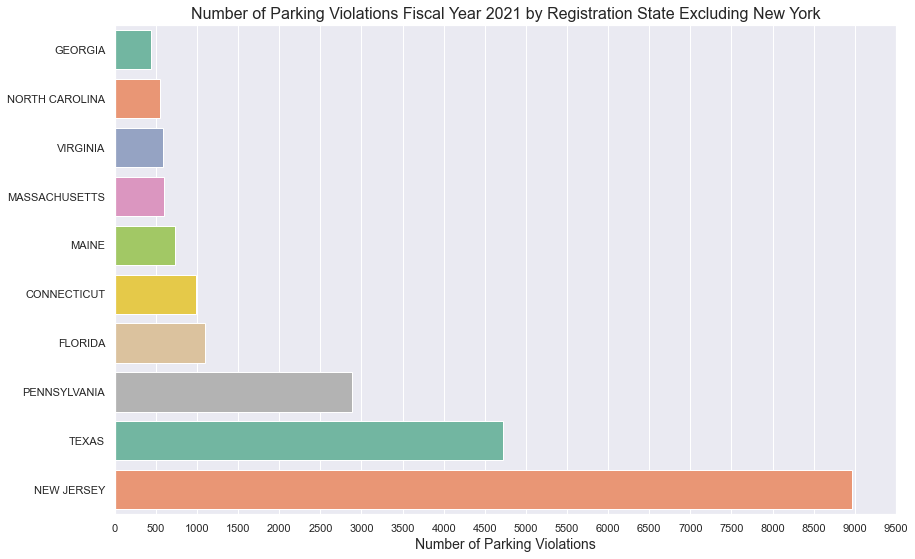

In [62]:
states_table = pd.DataFrame(df.registration_state.value_counts())
states_table.sort_values('registration_state', ascending = False, inplace = True)

states_df = df[(df['registration_state'] != 'NEW YORK') & (df['registration_state'] != '99')]
states = pd.DataFrame(states_df.registration_state.value_counts().head(10)).sort_values('registration_state')
yvalues = states.index

sns.set(style="darkgrid")
plt.figure(figsize=(14, 9))

sns.barplot(x=states.registration_state, y=yvalues, palette='Set2')
plt.title('Number of Parking Violations Fiscal Year 2021 by Registration State Excluding New York', size = 16)
plt.xlabel('Number of Parking Violations', size = 14)
plt.xlim(0,9501)
plt.xticks(np.arange(0,10000,500))
plt.show()

Suprising to see that NY's neighboring states of NJ, PA, and CT do not make up the top 3. Why are they split by Texas and Florida in particular?
- An interesting consideration is that some NYC residents opt to register their cars in these states to take advantage of <a href='https://www.nbcnewyork.com/investigations/changes-at-texas-dmv-could-lead-to-fewer-temporary-texas-paper-plates-in-ny/3547355/'> cheaper registration fees and for other nefarious purposes</a>. 